# Introduction 

This project is to find the opportunities​ ​to​ ​increase​ ​successful​ ​guest-host​ ​matching​ ​using the datasets of Airbnb's inquiry records. According to the exploratory analysis results of the datasets, inquiries usually follow the steps of receiving reply from hosts, and/or acceptance from hosts, and confirmation from guests to be successfully booked. This notebook aims to find the drivers of the three steps. 

# Summary of results

Three kinds of models were built for each step (reply, acceptance, and confirmation for booking): 
* Random Forest
* Logistic Regression with numerical features
* Logistic Regression with binned numerical features

## Drivers of reply
RF model(AUC score: 0.65) and logistic regression model with binned numerical features(AUC score: 0.64) has similar performance, and in order to see the interactions between features more clearly, I would still use the later model.

The final model shows number of reviews for the listing, first message length, and lead time are the most important drivers. More specifically, inquiries for listings with more reviews are more likely to be replied, where listings with zero reviews are likely to not receive a reply; messages with 151-300 characters are more likely to be replied, messages too short(0-150 characters) or too long(>450) both have a relatively lower chance to be replied; lead time too short(1-30d) or too long(>90d) both have a lower chance to be replied.

Therefore, encouraging guests to send a proper length message when making the inquiries; promote new host's listings so that they have higher chance to receive reviews and encourage guests to leave a review after completing their stays might increase the reply rate.


## Drivers of acceptance
Random Forest model has the best performance(AUC score: 0.88), but in order to see the interactions between features more clearly, I would still use logistic regression model with binned numerical features(AUC score: 0.78) as the final model

The final model results showed that: 
*   Hosts are more likely to accept the inquiry when: interactions >20, reviews >10, lead time is 31-60 days, stays is 11-15 days, message of 150-450 characters, and guest size is 1.
*   Hosts are less likely to accept the inquiry when: interaction less than 10, lead time greater than 90 days, days of stay greater than 15, guest size great than or equal to 3

And there are interesting findings about interaction features:





Can consider encouraging interactions, quick replies, and reviews to increase acceptance rate. 


## Drivers of confirmation for booking
Logistic regression model with numerical features has the best performance(AUC score: 0.90), but used logistic regression model with binned numerical features(AUC score: 0.86) as the final model in order to see the interactions between features. 

Results showing frequent interactions, longer accept time and past users are drivers of confirmation. 


# Load Data and Packages

In [1]:
# load packages
%matplotlib inline
import io
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from google.colab import files
uploaded = files.upload()

Saving accepted_inquiries.csv to accepted_inquiries.csv


In [3]:
import io
import pandas as pd
all_inquiries_df = pd.read_csv(io.BytesIO(uploaded['all_inquiries.csv']))

In [5]:
replied_inquiries_df = pd.read_csv(io.BytesIO(uploaded['replied_inquiries.csv']))

In [7]:
accepted_inquiries_df = pd.read_csv(io.BytesIO(uploaded['accepted_inquiries.csv']))

In [ ]:
# from google.colab import files

# accepted_inquiries.to_csv('accepted_inquiries.csv')
# files.download('accepted_inquiries.csv')

# All inquiries

The goal in this section is to find **what drives hosts' reply** for all inquiries in Contact Me and Book It channel using ML models.

Inquiries in **Instant Book channel** and inquiries where **reply timestamp equals accept timestamp** are **excluded**.

In [ ]:
# check the propotion of replied = 1
y = all_inquiries_df['replied']
print(y.sum() / y.shape * 100)

[87.8505254]


Since most of the inquiries are replied, we are interested in what causes inquitires to be not replied.

## Random forest 

In [ ]:
# Check what features are included
all_inquiries = all_inquiries_df.copy()
all_inquiries = all_inquiries.drop(columns=['Unnamed: 0'])

all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          16083 non-null  float64
 1   message_length      16083 non-null  float64
 2   total_reviews       16083 non-null  float64
 3   lead_time           16083 non-null  int64  
 4   days_of_stay        16083 non-null  int64  
 5   replied             16083 non-null  int64  
 6   rt_Entire_home/apt  16083 non-null  int64  
 7   rt_Private room     16083 non-null  int64  
 8   rt_Shared room      16083 non-null  int64  
 9   contact_me          16083 non-null  int64  
 10  past_booker         16083 non-null  int64  
 11  not_replied         16083 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.5 MB


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

# Not_replied is the positive behavior that we are observing
X = all_inquiries.drop(['replied', 'not_replied'], axis = 1)
y = all_inquiries['not_replied']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 
# model_train, model_test = train_test_split(all_inquiries, test_size=0.15, random_state = 3)
# model_train_x = model_train.drop(['replied', 'not_replied'], axis = 1)
# model_test_x = model_test.drop(['replied', 'not_replied'], axis = 1)
# model_train_y = model_train['not_replied']
# model_test_y = model_test['not_replied']

### Train model and find optimal hypermarameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    # np.arange(80,90)
    'class_weight' : ["balanced", "balanced_subsample", None],
    'n_estimators' : [60, 80, 90],
    'max_depth' : [6, 7, 8, 9, 10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

# best random forest
best_RF_model = Grid_RF.best_estimator_

Best score: 0.879
Best parameters set:
	class_weight: None
	max_depth: 9
	n_estimators: 90


### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Replied','Not_replied']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_RF_model.predict(model_test_x))

array([[2120,    0],
       [ 293,    0]])

Logistic Regression
Accuracy is: 0.879
precision is: nan
recall is: 0.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


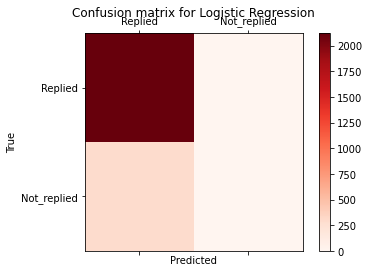

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_RF_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(model_test_x)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(model_test_y, y_pred_rf)

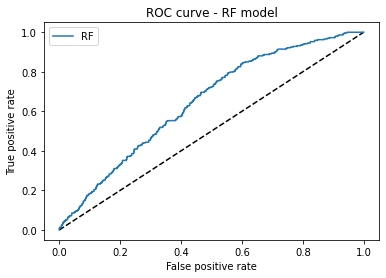

In [ ]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.6465153905595983

### Feature selection

In [ ]:
# check feature importance of random forest for feature selection
forest = best_RF_model
forest.fit(model_train_x, model_train_y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), model_train_x.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
message_length: 0.2396
total_reviews: 0.2356
lead_time: 0.2054
days_of_stay: 0.1394
guest_size: 0.0909
past_booker: 0.025
contact_me: 0.0249
rt_Private room: 0.0177
rt_Entire_home/apt: 0.0136
rt_Shared room: 0.0079


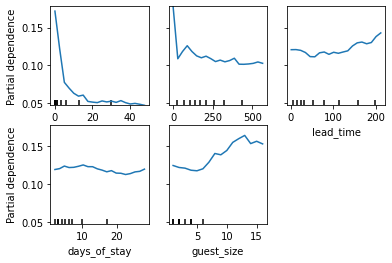

In [ ]:
from sklearn.inspection import plot_partial_dependence

features = ['total_reviews', 'message_length', 'lead_time', 'days_of_stay', 'guest_size']
plot_partial_dependence(best_RF_model, model_train_x, features,
                        n_jobs=4, grid_resolution=20)

## Logistic regression (numerical)

In [ ]:
# Check what features are included
all_inquiries = all_inquiries_df.copy()
all_inquiries = all_inquiries.drop(columns=['Unnamed: 0'])

all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          16083 non-null  float64
 1   message_length      16083 non-null  float64
 2   total_reviews       16083 non-null  float64
 3   lead_time           16083 non-null  int64  
 4   days_of_stay        16083 non-null  int64  
 5   replied             16083 non-null  int64  
 6   rt_Entire_home/apt  16083 non-null  int64  
 7   rt_Private room     16083 non-null  int64  
 8   rt_Shared room      16083 non-null  int64  
 9   contact_me          16083 non-null  int64  
 10  past_booker         16083 non-null  int64  
 11  not_replied         16083 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.5 MB


### Feature Preprocessing

#### Interaction features

In [ ]:
all_inquiries['contact_me*past_booker'] = all_inquiries['contact_me'] * all_inquiries['past_booker']
all_inquiries['contact_me*lead_time'] = all_inquiries['contact_me'] * all_inquiries['lead_time']
all_inquiries['contact_me*guest size'] = all_inquiries['contact_me'] * all_inquiries['guest_size']

all_inquiries['message_length*lead_time'] = all_inquiries['message_length'] * all_inquiries['lead_time']
all_inquiries['message_length*days_of_stay'] = all_inquiries['message_length'] * all_inquiries['days_of_stay']

all_inquiries['guest_size*rt_Entire_home/apt'] = all_inquiries['guest_size'] * all_inquiries['rt_Entire_home/apt']
all_inquiries['guest_size*rt_Private room'] = all_inquiries['guest_size'] * all_inquiries['rt_Private room']
all_inquiries['guest_size*rt_Shared room'] = all_inquiries['guest_size'] * all_inquiries['rt_Shared room']

all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   guest_size                     16083 non-null  float64
 1   message_length                 16083 non-null  float64
 2   total_reviews                  16083 non-null  float64
 3   lead_time                      16083 non-null  int64  
 4   days_of_stay                   16083 non-null  int64  
 5   replied                        16083 non-null  int64  
 6   rt_Entire_home/apt             16083 non-null  int64  
 7   rt_Private room                16083 non-null  int64  
 8   rt_Shared room                 16083 non-null  int64  
 9   contact_me                     16083 non-null  int64  
 10  past_booker                    16083 non-null  int64  
 11  not_replied                    16083 non-null  int64  
 12  contact_me*past_booker         16083 non-null 

#### Feature scaling

In [ ]:
# scale all features but categorical ones
from sklearn import preprocessing

scale_list = list(all_inquiries.columns)
scale_list.remove('replied')
scale_list.remove('not_replied')
scale_list.remove('contact_me')
scale_list.remove('past_booker')
scale_list.remove('rt_Entire_home/apt')
scale_list.remove('rt_Private room')
scale_list.remove('rt_Shared room')

# MinMax scaling
sc_scale = preprocessing.MinMaxScaler().fit(all_inquiries[scale_list])
all_inquiries[scale_list] = sc_scale.transform(all_inquiries[scale_list])


In [ ]:
all_inquiries.head(10)

,guest_size,message_length,total_reviews,lead_time,days_of_stay,replied,rt_Entire_home/apt,rt_Private room,rt_Shared room,contact_me,past_booker,not_replied,contact_me*past_booker,contact_me*lead_time,contact_me*guest size,message_length*lead_time,message_length*days_of_stay,guest_size*rt_Entire_home/apt,guest_size*rt_Private room,guest_size*rt_Shared room
0,0.267,0.160,0.000,0.267,0.027,1,1,0,0,1,1,0,1.000,0.267,0.312,0.137,0.016,0.312,0.000,0.000
1,0.000,0.084,0.183,0.070,0.022,1,0,1,0,1,0,0,0.000,0.070,0.062,0.019,0.007,0.000,0.062,0.000
2,0.000,0.179,0.000,0.009,0.011,1,1,0,0,1,0,0,0.000,0.009,0.062,0.005,0.008,0.062,0.000,0.000
3,0.333,0.015,0.000,0.102,0.019,1,1,0,0,1,1,0,1.000,0.102,0.375,0.005,0.001,0.375,0.000,0.000
4,0.200,0.066,0.011,0.162,0.011,1,1,0,0,0,0,0,0.000,0.000,0.000,0.034,0.003,0.250,0.000,0.000
5,0.200,0.066,0.011,0.039,0.005,1,1,0,0,1,0,0,0.000,0.039,0.250,0.008,0.002,0.250,0.000,0.000
6,0.200,0.144,0.000,0.108,0.011,1,1,0,0,0,0,0,0.000,0.000,0.000,0.050,0.006,0.250,0.000,0.000
7,0.133,0.085,0.045,0.165,0.038,1,1,0,0,0,0,0,0.000,0.000,0.000,0.045,0.011,0.188,0.000,0.000
8,0.000,0.203,0.034,0.061,0.245,1,1,0,0,0,1,0,0.000,0.000,0.000,0.039,0.161,0.062,0.000,0.000
9,0.133,0.101,0.000,0.323,0.025,0,1,0,0,0,0,1,0.000,0.000,0.000,0.104,0.009,0.188,0.000,0.000


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

# Not_replied is the positive behavior that we are observing
X = all_inquiries.drop(['replied', 'not_replied'], axis = 1)
y = all_inquiries['not_replied']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 
# model_train, model_test = train_test_split(all_inquiries, test_size=0.15, random_state = 3)
# model_train_x = model_train.drop(['replied', 'not_replied'], axis = 1)
# model_test_x = model_test.drop(['replied', 'not_replied'], axis = 1)
# model_train_y = model_train['not_replied']
# model_test_y = model_test['not_replied']

### Train model and find optimal hypermarameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
from sklearn.linear_model import LogisticRegression
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5), ('l1', 10) ('l2', 1) ('l2', 5), ('l2', 10)
parameters = {
    # ('l1', 'l2')
    'penalty':['l2'],
    'class_weight' : ["balanced", None],
    'C':np.logspace (-2, 2, num=100)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

KeyboardInterrupt: ignored

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.878
Best parameters set:
	C: 0.01
	penalty: 'l2'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Replied','Not_replied']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[2120,    0],
       [ 293,    0]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Logistic Regression
Accuracy is: 0.879
precision is: nan
recall is: 0.000


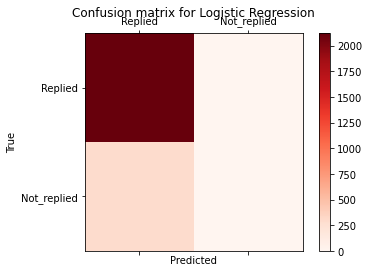

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

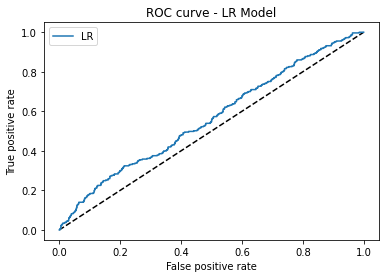

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.5633999291647884

### Feature selection

In [ ]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


total_reviews: -0.3257
contact_me: -0.2564
message_length: -0.1683
lead_time: 0.1328
contact_me*past_booker: 0.065
contact_me*lead_time: 0.0553
guest_size*rt_Entire_home/apt: 0.0492
guest_size: 0.0344
past_booker: -0.0282
message_length*days_of_stay: -0.0175
contact_me*guest size: -0.0167
rt_Entire_home/apt: -0.0111
guest_size*rt_Private room: -0.0097
guest_size*rt_Shared room: -0.0073
rt_Shared room: 0.0071
message_length*lead_time: -0.0066
rt_Private room: 0.0043
days_of_stay: -0.0018


## Logistic regression (binned numerical)

In [8]:
# Check what features are included
all_inquiries = all_inquiries_df.copy()
all_inquiries = all_inquiries.drop(columns=['Unnamed: 0'])

all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          16083 non-null  float64
 1   message_length      16083 non-null  float64
 2   total_reviews       16083 non-null  float64
 3   lead_time           16083 non-null  int64  
 4   days_of_stay        16083 non-null  int64  
 5   replied             16083 non-null  int64  
 6   rt_Entire_home/apt  16083 non-null  int64  
 7   rt_Private room     16083 non-null  int64  
 8   rt_Shared room      16083 non-null  int64  
 9   contact_me          16083 non-null  int64  
 10  past_booker         16083 non-null  int64  
 11  not_replied         16083 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.5 MB


### Feature Preprocessing

#### Feature encoding

In order to see the nuances of some features' impact, I decided to create buckets for numerical variables including:
*   Review
*   Lead time
*   Days of stay
*   Message length
*   Guest size




In [9]:
# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(all_inquiries['total_reviews'], bins = review, labels=review_range)
all_inquiries['reviews'] = reviews_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(all_inquiries['lead_time'], bins = lead, labels=lead_range)
all_inquiries['lead_time'] = lead_bin

# Binning days_of_stay
stay = [-1,5,10,15,1000]
stay_range = ['1-5d','6-10d','11-15d','>15d']
stay_bin = pd.cut(all_inquiries['days_of_stay'], bins = stay, labels=stay_range)
all_inquiries['days_of_stay'] = stay_bin

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(all_inquiries['message_length'], bins = length, labels=length_range)
all_inquiries['message_length'] = length_bin

# Binning guest size
size = [-1,1,2,4,6,30]
size_range = ['1','2','3-4','5-6','>6']
size_bin = pd.cut(all_inquiries['guest_size'], bins = size, labels=size_range)
all_inquiries['guest_size'] = size_bin

In [10]:
# generate binary values using get_dummies
all_inquiries = pd.get_dummies(all_inquiries, columns=["reviews", "lead_time", "days_of_stay", "message_length", "guest_size"] )

In [11]:
# Drop columns not to be used
all_inquiries = all_inquiries.drop(['total_reviews'], axis = 1)

In [12]:
all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   replied                 16083 non-null  int64
 1   rt_Entire_home/apt      16083 non-null  int64
 2   rt_Private room         16083 non-null  int64
 3   rt_Shared room          16083 non-null  int64
 4   contact_me              16083 non-null  int64
 5   past_booker             16083 non-null  int64
 6   not_replied             16083 non-null  int64
 7   reviews_0               16083 non-null  uint8
 8   reviews_1-10            16083 non-null  uint8
 9   reviews_11-20           16083 non-null  uint8
 10  reviews_21-30           16083 non-null  uint8
 11  reviews_>30             16083 non-null  uint8
 12  lead_time_1-30d         16083 non-null  uint8
 13  lead_time_31-60d        16083 non-null  uint8
 14  lead_time_61-90d        16083 non-null  uint8
 15  lead_time_>90d     

#### Interaction features

Creat interaction features to discover combined effects of independent variables

In [13]:
# Interaction features

room_types = all_inquiries.columns[1:4]
reviews = all_inquiries.columns[7:12]
lead_times = all_inquiries.columns[12:16]
stays = all_inquiries.columns[16:20]
message_lengths = all_inquiries.columns[20:24]
guest_sizes = all_inquiries.columns[24:29]

# Channel * user stage
all_inquiries['contact_me*past_booker'] = all_inquiries['contact_me'] * all_inquiries['past_booker']

# Channel * lead_time
for i in lead_times:
  all_inquiries['contact_me'+'*'+i] = all_inquiries['contact_me'] * all_inquiries[i]

# Channel * guest size
for i in guest_sizes:
  all_inquiries['contact_me'+'*'+i] = all_inquiries['contact_me'] * all_inquiries[i]

# Message length * days of stay
for i in message_lengths:
  for j in stays:
    all_inquiries[i+'*'+j] = all_inquiries[i] * all_inquiries[j]

# Message length * lead time
for i in message_lengths:
  for j in lead_times:
    all_inquiries[i+'*'+j] = all_inquiries[i] * all_inquiries[j]

# Room type * guest size
for i in room_types:
  for j in guest_sizes:
    all_inquiries[i+'*'+j] = all_inquiries[i] * all_inquiries[j]

In [ ]:
all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 86 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   replied                                     16083 non-null  int64
 1   rt_Entire_home/apt                          16083 non-null  int64
 2   rt_Private room                             16083 non-null  int64
 3   rt_Shared room                              16083 non-null  int64
 4   contact_me                                  16083 non-null  int64
 5   past_booker                                 16083 non-null  int64
 6   not_replied                                 16083 non-null  int64
 7   reviews_0                                   16083 non-null  uint8
 8   reviews_1-10                                16083 non-null  uint8
 9   reviews_11-20                               16083 non-null  uint8
 10  reviews_21-30                     

#### Split training and test data

In [14]:
from sklearn.model_selection import train_test_split

# Not_replied is the positive behavior that we are observing
X = all_inquiries.drop(['replied', 'not_replied'], axis = 1)
y = all_inquiries['not_replied']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 
# model_train, model_test = train_test_split(all_inquiries, test_size=0.15, random_state = 3)
# model_train_x = model_train.drop(['replied', 'not_replied'], axis = 1)
# model_test_x = model_test.drop(['replied', 'not_replied'], axis = 1)
# model_train_y = model_train['not_replied']
# model_test_y = model_test['not_replied']

### Train model and find optimal hypermarameters

In [16]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [18]:
from sklearn.linear_model import LogisticRegression
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    # ('l1', 'l2')
    'penalty':['l1'],
    'solver':['liblinear'],
    'class_weight' : ["balanced", None],
    'C':np.logspace (-1.5, 1.5, num=50)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.03162278,  0.03641...
        2.1713743 ,  2.50011038,  2.87861559,  3.31442475,  3.81621341,
        4.39397056,  5.05919749,  5.82513671,  6.70703561,  7.72244995,
        8.89159334, 10.23773966, 11.78768635, 13.57228783, 15.62706977,
       17.99293623, 20.716984  , 23.85344006, 27.46474115, 31.6227766 ]),


In [19]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.878
Best parameters set:
	C: 0.03162277660168379
	class_weight: None
	penalty: 'l1'
	solver: 'liblinear'


In [20]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Replied','Not_Replied']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [22]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[2120,    0],
       [ 293,    0]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Logistic Regression
Accuracy is: 0.879
precision is: nan
recall is: 0.000


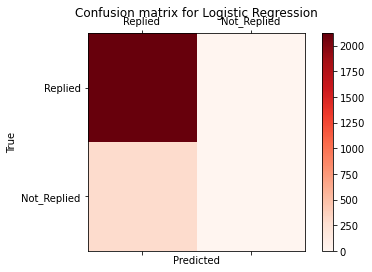

In [23]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [24]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

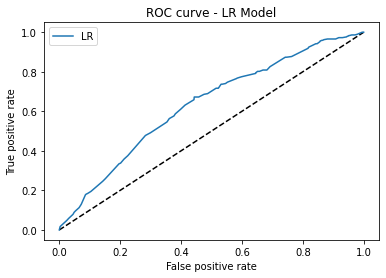

In [25]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [26]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.6325101423143795

### Feature selection

In [ ]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


reviews_0: 0.5685
reviews_>30: -0.5224
contact_me: -0.3207
reviews_11-20: -0.2545
message_length_0-150: 0.1367
lead_time_31-60d: -0.0529
lead_time_>90d: 0.0307
rt_Entire_home/apt: -0.0077
contact_me*guest_size_1: 0.0
contact_me*guest_size_2: 0.0
contact_me*guest_size_3-4: 0.0
contact_me*guest_size_5-6: 0.0
contact_me*guest_size_>6: 0.0
contact_me*lead_time_1-30d: 0.0
contact_me*lead_time_31-60d: 0.0
contact_me*lead_time_61-90d: 0.0
contact_me*lead_time_>90d: 0.0
contact_me*past_booker: 0.0
days_of_stay_1-5d: 0.0
days_of_stay_11-15d: 0.0
days_of_stay_6-10d: 0.0
days_of_stay_>15d: 0.0
guest_size_1: 0.0
guest_size_2: 0.0
guest_size_3-4: 0.0
guest_size_5-6: 0.0
guest_size_>6: 0.0
lead_time_1-30d: 0.0
lead_time_61-90d: 0.0
message_length_0-150*days_of_stay_1-5d: 0.0
message_length_0-150*days_of_stay_11-15d: 0.0
message_length_0-150*days_of_stay_6-10d: 0.0
message_length_0-150*days_of_stay_>15d: 0.0
message_length_0-150*lead_time_1-30d: 0.0
message_length_0-150*lead_time_31-60d: 0.0
message_

## Final model

* RF model results: **message_length**, **total_reviews**, and **lead_time** are the most important features

* Logistic regression model with numerical features results: **total_reviews**, **channel(contact_me)**, **message_length**, and **lead_time** are the most important features

* Logistic regression model for binned numerical features results: **total_reviews**, **channel(contact_me)**, **message_length**, and **lead_time** are the most important features

RF model(AUC score: 0.65) and logistic regression model with binned numerical features(AUC score: 0.63) has similar performance, and in order to see the interactions between features more clearly, I would still use the later model.

In [27]:
# Check what features are included
all_inquiries = all_inquiries_df.copy()
all_inquiries = all_inquiries[['not_replied', 'message_length', 'total_reviews', 'contact_me', 'lead_time']]

all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   not_replied     16083 non-null  int64  
 1   message_length  16083 non-null  float64
 2   total_reviews   16083 non-null  float64
 3   contact_me      16083 non-null  int64  
 4   lead_time       16083 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 628.4 KB


#### Feature encoding

In [28]:
# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(all_inquiries['total_reviews'], bins = review, labels=review_range)
all_inquiries['reviews'] = reviews_bin
all_inquiries = all_inquiries.drop(columns=['total_reviews'])

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(all_inquiries['message_length'], bins = length, labels=length_range)
all_inquiries['message_length'] = length_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(all_inquiries['lead_time'], bins = lead, labels=lead_range)
all_inquiries['lead_time'] = lead_bin

In [29]:
# generate binary values using get_dummies
all_inquiries = pd.get_dummies(all_inquiries, columns=["reviews", "message_length", "lead_time"] )

all_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16083 entries, 0 to 16082
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   not_replied             16083 non-null  int64
 1   contact_me              16083 non-null  int64
 2   reviews_0               16083 non-null  uint8
 3   reviews_1-10            16083 non-null  uint8
 4   reviews_11-20           16083 non-null  uint8
 5   reviews_21-30           16083 non-null  uint8
 6   reviews_>30             16083 non-null  uint8
 7   message_length_0-150    16083 non-null  uint8
 8   message_length_151-300  16083 non-null  uint8
 9   message_length_301-450  16083 non-null  uint8
 10  message_length_>450     16083 non-null  uint8
 11  lead_time_1-30d         16083 non-null  uint8
 12  lead_time_31-60d        16083 non-null  uint8
 13  lead_time_61-90d        16083 non-null  uint8
 14  lead_time_>90d          16083 non-null  uint8
dtypes: int64(2), uint8(

#### Split training and test data

In [30]:
from sklearn.model_selection import train_test_split

# Not_replied is the positive behavior that we are observing
X = all_inquiries.drop(['not_replied'], axis = 1)
y = all_inquiries['not_replied']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 
# model_train, model_test = train_test_split(all_inquiries, test_size=0.15, random_state = 3)
# model_train_x = model_train.drop(['replied', 'not_replied'], axis = 1)
# model_test_x = model_test.drop(['replied', 'not_replied'], axis = 1)
# model_train_y = model_train['not_replied']
# model_test_y = model_test['not_replied']

### Train model and find optimal hypermarameters

In [31]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    # ('l1', 'l2')
    'penalty':['l2'],
    'class_weight' : ["balanced", None],
    'C':np.logspace (-2, 5, num=100)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-02, 1.1...
       8.69749003e+03, 1.02353102e+04, 1.20450354e+04, 1.41747416e+04,
       1.66810054e+04, 1.96304065e+04, 2.31012970e+04, 2.71858824e+04,
       3.19926714e+04, 3.76493581e+04, 4.43062146e+04, 5.21400829e+04,
       6.13590727e+04, 7.22080902e+04, 8.49753436e+04, 1.00000000e+05]),
      

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.878
Best parameters set:
	C: 0.01
	class_weight: None
	penalty: 'l2'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Replied','Not_Replied']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[2120,    0],
       [ 293,    0]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Logistic Regression
Accuracy is: 0.879
precision is: nan
recall is: 0.000


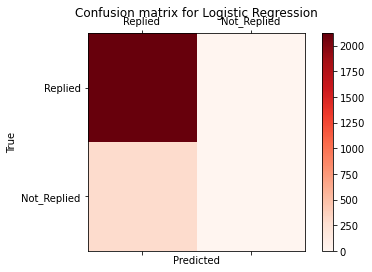

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

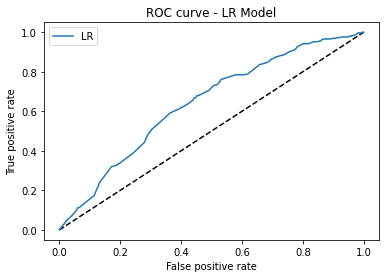

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.6412615107218752

### Results interpretation

In [ ]:
# Store the coef for results interpretation
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


reviews_0: 0.6224
reviews_>30: -0.355
contact_me: -0.267
reviews_11-20: -0.2322
message_length_0-150: 0.1788
reviews_21-30: -0.1698
reviews_1-10: 0.1344
lead_time_>90d: 0.1183
lead_time_31-60d: -0.1063
message_length_>450: -0.0792
message_length_301-450: -0.0668
message_length_151-300: -0.033
lead_time_61-90d: -0.0256
lead_time_1-30d: 0.0135


In [ ]:
reviews = all_inquiries.columns[2:7]
message_lengths = all_inquiries.columns[7:11]
lead_times = all_inquiries.columns[11:15]

res = res.set_index('Feature')

print('contact_me: ' + str(res.Coef.loc['contact_me'])) 

for i in list(reviews):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(message_lengths):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(lead_times):
  print(i + ": " + str(res.Coef.loc[i]))

contact_me: -0.267
reviews_0: 0.6224
reviews_1-10: 0.1344
reviews_11-20: -0.2322
reviews_21-30: -0.1698
reviews_>30: -0.355
message_length_0-150: 0.1788
message_length_151-300: -0.033
message_length_301-450: -0.0668
message_length_>450: -0.0792
lead_time_1-30d: 0.0135
lead_time_31-60d: -0.1063
lead_time_61-90d: -0.0256
lead_time_>90d: 0.1183


*   Inquiries in contact me channel are more likely to be replied.
*   0 review is associated with non-replies, and >10 reviews drives reply
*   Messages with 151-300 characters are most likely to be replied, messages too short(0-150 characters) or too long(>450) both have a lower chance to be replied.
*   Lead time too short(1-30d) or too long(>90d) both have a lower chance to be replied.




In [ ]:
from google.colab import files

res.to_csv('mod1_res.csv')
files.download('mod1_res.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Replied inquiries

The goal in this section is to find **what drives hosts' acceptance** for replied inquiries in Contact Me and Book It channel using ML models.

Inquiries where **reply timestamp equals accept timestamp** are **excluded**.

In [ ]:
# check the propotion of accepted = 1
y = replied_inquiries_df['accepted']
print(y.sum() / y.shape * 100)

[34.94231722]


The number of inquiries that were accepted is less than those weren't

## Random forest 

In [ ]:
# Check what features are included
replied_inquiries = replied_inquiries_df.copy()
replied_inquiries = replied_inquiries.drop(columns=['Unnamed: 0'])

replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          14129 non-null  float64
 1   total_interactions  14129 non-null  int64  
 2   message_length      14129 non-null  float64
 3   total_reviews       14129 non-null  float64
 4   lead_time           14129 non-null  int64  
 5   days_of_stay        14129 non-null  int64  
 6   reply_t             14129 non-null  float64
 7   accepted            14129 non-null  int64  
 8   rt_Entire_home/apt  14129 non-null  int64  
 9   rt_Private room     14129 non-null  int64  
 10  rt_Shared room      14129 non-null  int64  
 11  contact_me          14129 non-null  int64  
 12  past_booker         14129 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.4 MB


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = replied_inquiries.drop(['accepted'], axis = 1)
y = replied_inquiries['accepted']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    #'n_estimators' : np.arange(65,75)
    'n_estimators' : [60, 70, 80],
    'max_depth' : [10, 15, 20]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

# best random forest
best_RF_model = Grid_RF.best_estimator_

Best score: 0.789
Best parameters set:
	max_depth: 10
	n_estimators: 60


### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_accepted','Accepted']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_RF_model.predict(model_test_x))

array([[1241,  138],
       [ 290,  451]])

Logistic Regression
Accuracy is: 0.798
precision is: 0.766
recall is: 0.609


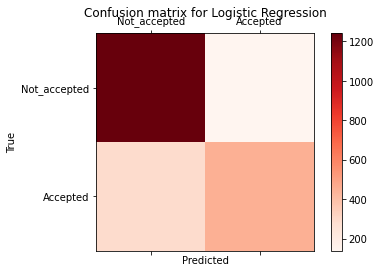

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_RF_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(model_test_x)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(model_test_y, y_pred_rf)

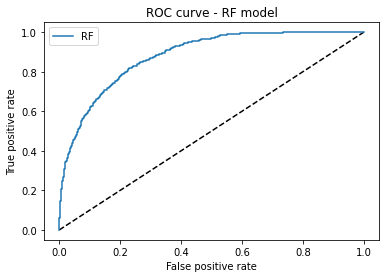

In [ ]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.8804782358081851

### Feature selection

In [ ]:
# check feature importance of random forest for feature selection
forest = best_RF_model
forest.fit(model_train_x, model_train_y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), model_train_x.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_interactions: 0.5197
total_reviews: 0.1125
reply_t: 0.1087
lead_time: 0.0787
message_length: 0.0552
days_of_stay: 0.0467
contact_me: 0.0311
guest_size: 0.0246
past_booker: 0.0081
rt_Entire_home/apt: 0.0054
rt_Private room: 0.0047
rt_Shared room: 0.0045


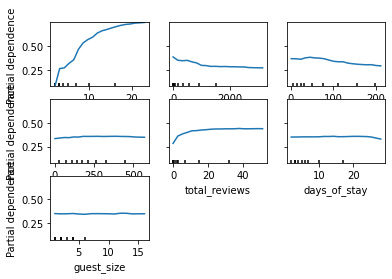

In [ ]:
from sklearn.inspection import plot_partial_dependence

features = ['total_interactions', 'reply_t', 'lead_time', 'message_length', 'total_reviews', 'days_of_stay', 'guest_size']
plot_partial_dependence(best_RF_model, model_train_x, features,
                        n_jobs=4, grid_resolution=20)

Interactions, reviews, reply_t, lead_time, message_length, days_of_stay, channel, guest_size and are the most important features according to RF model results

## Logistic regression (numerical)

In [ ]:
# Check what features are included
replied_inquiries = replied_inquiries_df.copy()
replied_inquiries = replied_inquiries.drop(columns=['Unnamed: 0'])

replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          14129 non-null  float64
 1   total_interactions  14129 non-null  int64  
 2   message_length      14129 non-null  float64
 3   total_reviews       14129 non-null  float64
 4   lead_time           14129 non-null  int64  
 5   days_of_stay        14129 non-null  int64  
 6   reply_t             14129 non-null  float64
 7   accepted            14129 non-null  int64  
 8   rt_Entire_home/apt  14129 non-null  int64  
 9   rt_Private room     14129 non-null  int64  
 10  rt_Shared room      14129 non-null  int64  
 11  contact_me          14129 non-null  int64  
 12  past_booker         14129 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.4 MB


### Feature Preprocessing

#### Interaction features

In [ ]:
replied_inquiries['interaction*message_length'] = replied_inquiries['total_interactions'] * replied_inquiries['message_length']
replied_inquiries['interaction*lead_time'] = replied_inquiries['total_interactions'] * replied_inquiries['lead_time']
replied_inquiries['interaction*days_of_stay'] = replied_inquiries['total_interactions'] * replied_inquiries['days_of_stay']
replied_inquiries['interaction*past_booker'] = replied_inquiries['total_interactions'] * replied_inquiries['past_booker']

replied_inquiries['contact_me*past_booker'] = replied_inquiries['contact_me'] * replied_inquiries['past_booker']
replied_inquiries['contact_me*lead_time'] = replied_inquiries['contact_me'] * replied_inquiries['lead_time']
replied_inquiries['contact_me*guest size'] = replied_inquiries['contact_me'] * replied_inquiries['guest_size']

replied_inquiries['message_length*lead_time'] = replied_inquiries['message_length'] * replied_inquiries['lead_time']
replied_inquiries['message_length*days_of_stay'] = replied_inquiries['message_length'] * replied_inquiries['days_of_stay']

replied_inquiries['guest_size*rt_Entire_home/apt'] = replied_inquiries['guest_size'] * replied_inquiries['rt_Entire_home/apt']
replied_inquiries['guest_size*rt_Private room'] = replied_inquiries['guest_size'] * replied_inquiries['rt_Private room']
replied_inquiries['guest_size*rt_Shared room'] = replied_inquiries['guest_size'] * replied_inquiries['rt_Shared room']

replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   guest_size                     14129 non-null  float64
 1   total_interactions             14129 non-null  int64  
 2   message_length                 14129 non-null  float64
 3   total_reviews                  14129 non-null  float64
 4   lead_time                      14129 non-null  int64  
 5   days_of_stay                   14129 non-null  int64  
 6   reply_t                        14129 non-null  float64
 7   accepted                       14129 non-null  int64  
 8   rt_Entire_home/apt             14129 non-null  int64  
 9   rt_Private room                14129 non-null  int64  
 10  rt_Shared room                 14129 non-null  int64  
 11  contact_me                     14129 non-null  int64  
 12  past_booker                    14129 non-null 

#### Feature scaling

In [ ]:
from sklearn import preprocessing

scale_list = list(replied_inquiries.columns)
scale_list.remove('accepted')
scale_list.remove('contact_me')
scale_list.remove('past_booker')
scale_list.remove('rt_Entire_home/apt')
scale_list.remove('rt_Private room')
scale_list.remove('rt_Shared room')

# MinMax scaling
sc_scale = preprocessing.MinMaxScaler().fit(replied_inquiries[scale_list])
replied_inquiries[scale_list] = sc_scale.transform(replied_inquiries[scale_list])


In [ ]:
replied_inquiries.head(10)

,guest_size,total_interactions,message_length,total_reviews,lead_time,days_of_stay,reply_t,accepted,rt_Entire_home/apt,rt_Private room,rt_Shared room,contact_me,past_booker,interaction*message_length,interaction*lead_time,interaction*days_of_stay,interaction*past_booker,contact_me*past_booker,contact_me*lead_time,contact_me*guest size,message_length*lead_time,message_length*days_of_stay,guest_size*rt_Entire_home/apt,guest_size*rt_Private room,guest_size*rt_Shared room
0,0.267,0.000,0.160,0.000,0.267,0.027,0.000,0,1,0,0,1,1,0.010,0.018,0.002,0.011,1.000,0.267,0.312,0.137,0.016,0.312,0.000,0.000
1,0.000,0.006,0.084,0.183,0.070,0.022,0.000,0,0,1,0,1,0,0.008,0.007,0.002,0.000,0.000,0.070,0.062,0.019,0.007,0.000,0.062,0.000
2,0.000,0.029,0.179,0.000,0.009,0.011,0.000,0,1,0,0,1,0,0.039,0.002,0.003,0.000,0.000,0.009,0.062,0.005,0.008,0.062,0.000,0.000
3,0.333,0.029,0.015,0.000,0.102,0.019,0.000,1,1,0,0,1,1,0.003,0.024,0.004,0.040,1.000,0.102,0.375,0.005,0.001,0.375,0.000,0.000
4,0.200,0.023,0.066,0.011,0.162,0.011,0.000,0,1,0,0,0,0,0.012,0.032,0.002,0.000,0.000,0.000,0.000,0.034,0.003,0.250,0.000,0.000
5,0.200,0.000,0.066,0.011,0.039,0.005,0.002,0,1,0,0,1,0,0.004,0.003,0.000,0.000,0.000,0.039,0.250,0.008,0.002,0.250,0.000,0.000
6,0.200,0.023,0.144,0.000,0.108,0.011,0.007,0,1,0,0,0,0,0.027,0.021,0.002,0.000,0.000,0.000,0.000,0.050,0.006,0.250,0.000,0.000
7,0.133,0.017,0.085,0.045,0.165,0.038,0.004,0,1,0,0,0,0,0.013,0.027,0.006,0.000,0.000,0.000,0.000,0.045,0.011,0.188,0.000,0.000
8,0.000,0.806,0.203,0.034,0.061,0.245,0.000,1,1,0,0,0,1,0.903,0.287,1.000,0.808,0.000,0.000,0.000,0.039,0.161,0.062,0.000,0.000
9,0.200,0.017,0.042,0.078,0.076,0.016,0.000,0,1,0,0,0,1,0.006,0.013,0.003,0.028,0.000,0.000,0.000,0.010,0.003,0.250,0.000,0.000


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = replied_inquiries.drop(['accepted'], axis = 1)
y = replied_inquiries['accepted']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    # ('l1', 'l2')
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':np.logspace (-2.5, -0.1, num=50)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.00316228, 0.00353...
       0.05302611, 0.05935665, 0.06644296, 0.07437527, 0.08325459,
       0.09319396, 0.10431994, 0.11677421, 0.13071533, 0.14632082,
       0.16378937, 0.18334341, 0.20523192, 0.22973358, 0.25716039,
       0.28786156, 0.32222799, 0.36069727, 0.40375922, 0.45196212,
       0.50591975, 0.566

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.767
Best parameters set:
	C: 0.7943282347242815
	penalty: 'l1'
	solver: 'liblinear'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_accepted','Accepted']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[1291,   88],
       [ 398,  343]])

Logistic Regression
Accuracy is: 0.771
precision is: 0.796
recall is: 0.463


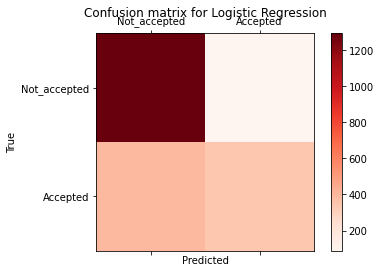

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

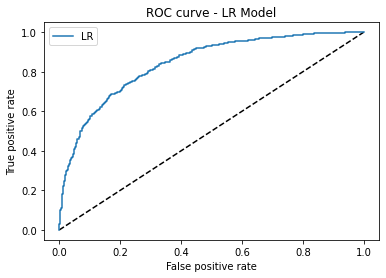

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8430104938253482

### Feature selection

In [ ]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


total_interactions: 30.5372
interaction*past_booker: 7.3789
reply_t: -5.3537
lead_time: -4.4733
total_reviews: 4.3929
contact_me*lead_time: 3.164
days_of_stay: -1.3666
interaction*days_of_stay: -1.2068
guest_size*rt_Shared room: -1.1918
interaction*message_length: 0.8611
rt_Entire_home/apt: -0.4708
rt_Private room: -0.4271
past_booker: -0.3262
guest_size: -0.29
interaction*lead_time: 0.2562
contact_me*guest size: 0.2529
contact_me: 0.1575
contact_me*past_booker: 0.0186
guest_size*rt_Entire_home/apt: 0.0
guest_size*rt_Private room: 0.0
message_length: 0.0
message_length*days_of_stay: 0.0
message_length*lead_time: 0.0
rt_Shared room: 0.0


Interactions, reviews, lead_time, reply_t, days_of_stay, guest size, room type, user_stage are important features according to logistic regression models with numerical features.


## Logistic regression (binned numerical)

In [ ]:
# Check what features are included
replied_inquiries = replied_inquiries_df.copy()
replied_inquiries = replied_inquiries.drop(columns=['Unnamed: 0'])

replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          14129 non-null  float64
 1   total_interactions  14129 non-null  int64  
 2   message_length      14129 non-null  float64
 3   total_reviews       14129 non-null  float64
 4   lead_time           14129 non-null  int64  
 5   days_of_stay        14129 non-null  int64  
 6   reply_t             14129 non-null  float64
 7   accepted            14129 non-null  int64  
 8   rt_Entire_home/apt  14129 non-null  int64  
 9   rt_Private room     14129 non-null  int64  
 10  rt_Shared room      14129 non-null  int64  
 11  contact_me          14129 non-null  int64  
 12  past_booker         14129 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.4 MB


### Feature Preprocessing

#### Feature encoding

In order to see the nuances of some features' impact, I decided to create buckets for numerical variables including:
*   Interaction
*   Review
*   Lead time
*   Days of stay
*   Message length
*   Guest size



And these bins will be used to create interactive features as well




In [ ]:
# Binning interactions
interaction = [0,10,20,30,1000]
interaction_range = ['1-10','11-20','21-30','>30']
interactions_bin = pd.cut(replied_inquiries['total_interactions'], bins = interaction, labels= interaction_range)
replied_inquiries['interactions'] = interactions_bin

# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(replied_inquiries['total_reviews'], bins = review, labels=review_range)
replied_inquiries['reviews'] = reviews_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(replied_inquiries['lead_time'], bins = lead, labels=lead_range)
replied_inquiries['lead_time'] = lead_bin

# Binning days_of_stay
stay = [-1,5,10,15,1000]
stay_range = ['1-5d','6-10d','11-15d','>15d']
stay_bin = pd.cut(replied_inquiries['days_of_stay'], bins = stay, labels=stay_range)
replied_inquiries['days_of_stay'] = stay_bin

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(replied_inquiries['message_length'], bins = length, labels=length_range)
replied_inquiries['message_length'] = length_bin

# Binning guest size
size = [-1,1,2,4,6,30]
size_range = ['1','2','3-4','5-6','>6']
size_bin = pd.cut(replied_inquiries['guest_size'], bins = size, labels=size_range)
replied_inquiries['guest_size'] = size_bin

In [ ]:
# generate binary values using get_dummies
replied_inquiries = pd.get_dummies(replied_inquiries, columns=["interactions", "reviews", "lead_time", "days_of_stay", "message_length", "guest_size"] )

In [ ]:
# Drop columns not to be used
replied_inquiries = replied_inquiries.drop(['total_interactions', 'total_reviews'], axis = 1)

In [ ]:
replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   reply_t                 14129 non-null  float64
 1   accepted                14129 non-null  int64  
 2   rt_Entire_home/apt      14129 non-null  int64  
 3   rt_Private room         14129 non-null  int64  
 4   rt_Shared room          14129 non-null  int64  
 5   contact_me              14129 non-null  int64  
 6   past_booker             14129 non-null  int64  
 7   interactions_1-10       14129 non-null  uint8  
 8   interactions_11-20      14129 non-null  uint8  
 9   interactions_21-30      14129 non-null  uint8  
 10  interactions_>30        14129 non-null  uint8  
 11  reviews_0               14129 non-null  uint8  
 12  reviews_1-10            14129 non-null  uint8  
 13  reviews_11-20           14129 non-null  uint8  
 14  reviews_21-30           14129 non-null

#### Interaction features

Creat interaction features to discover combined effects of independent variables

In [ ]:
# Interaction features

room_types = replied_inquiries.columns[2:5]
interactions = replied_inquiries.columns[7:11]
reviews = replied_inquiries.columns[11:16]
lead_times = replied_inquiries.columns[16:20]
stays = replied_inquiries.columns[20:24]
message_lengths = replied_inquiries.columns[24:28]
guest_sizes = replied_inquiries.columns[28:33]

# Interaction * message length
for i in interactions:
  for j in message_lengths:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Interaction * lead time
for i in interactions:
  for j in lead_times:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Interaction * days of stay
for i in interactions:
  for j in stays:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# User stage + interactions
for i in interactions:
    replied_inquiries['past_booker'+'*'+i] = replied_inquiries['past_booker'] * replied_inquiries[i]

# Channel * user stage
replied_inquiries['contact_me*past_booker'] = replied_inquiries['contact_me'] * replied_inquiries['past_booker']

# Channel * lead_time
for i in lead_times:
  replied_inquiries['contact_me'+'*'+i] = replied_inquiries['contact_me'] * replied_inquiries[i]

# Channel * guest size
for i in guest_sizes:
  replied_inquiries['contact_me'+'*'+i] = replied_inquiries['contact_me'] * replied_inquiries[i]

# Message length * days of stay
for i in message_lengths:
  for j in stays:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Message length * lead time
for i in message_lengths:
  for j in lead_times:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Room type * guest size
for i in room_types:
  for j in guest_sizes:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]


In [ ]:
replied_inquiries.head(10)

,reply_t,accepted,rt_Entire_home/apt,rt_Private room,rt_Shared room,contact_me,past_booker,interactions_1-10,interactions_11-20,interactions_21-30,interactions_>30,reviews_0,reviews_1-10,reviews_11-20,reviews_21-30,reviews_>30,lead_time_1-30d,lead_time_31-60d,lead_time_61-90d,lead_time_>90d,days_of_stay_1-5d,days_of_stay_6-10d,days_of_stay_11-15d,days_of_stay_>15d,message_length_0-150,message_length_151-300,message_length_301-450,message_length_>450,guest_size_1,guest_size_2,guest_size_3-4,guest_size_5-6,guest_size_>6,interactions_1-10*message_length_0-150,interactions_1-10*message_length_151-300,interactions_1-10*message_length_301-450,interactions_1-10*message_length_>450,interactions_11-20*message_length_0-150,interactions_11-20*message_length_151-300,interactions_11-20*message_length_301-450,...,message_length_151-300*days_of_stay_>15d,message_length_301-450*days_of_stay_1-5d,message_length_301-450*days_of_stay_6-10d,message_length_301-450*days_of_stay_11-15d,message_length_301-450*days_of_stay_>15d,message_length_>450*days_of_stay_1-5d,message_length_>450*days_of_stay_6-10d,message_length_>450*days_of_stay_11-15d,message_length_>450*days_of_stay_>15d,message_length_0-150*lead_time_1-30d,message_length_0-150*lead_time_31-60d,message_length_0-150*lead_time_61-90d,message_length_0-150*lead_time_>90d,message_length_151-300*lead_time_1-30d,message_length_151-300*lead_time_31-60d,message_length_151-300*lead_time_61-90d,message_length_151-300*lead_time_>90d,message_length_301-450*lead_time_1-30d,message_length_301-450*lead_time_31-60d,message_length_301-450*lead_time_61-90d,message_length_301-450*lead_time_>90d,message_length_>450*lead_time_1-30d,message_length_>450*lead_time_31-60d,message_length_>450*lead_time_61-90d,message_length_>450*lead_time_>90d,rt_Entire_home/apt*guest_size_1,rt_Entire_home/apt*guest_size_2,rt_Entire_home/apt*guest_size_3-4,rt_Entire_home/apt*guest_size_5-6,rt_Entire_home/apt*guest_size_>6,rt_Private room*guest_size_1,rt_Private room*guest_size_2,rt_Private room*guest_size_3-4,rt_Private room*guest_size_5-6,rt_Private room*guest_size_>6,rt_Shared room*guest_size_1,rt_Shared room*guest_size_2,rt_Shared room*guest_size_3-4,rt_Shared room*guest_size_5-6,rt_Shared room*guest_size_>6
0,83.583,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,159.150,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,264.033,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.567,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4.867,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,1269.617,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,4246.633,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,2370.017,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,22.050,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,16.333,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Feature scaling

In [ ]:
# Scale reply_t (MinMax scaling)
sc_scale = preprocessing.MinMaxScaler().fit(replied_inquiries[['reply_t']])
replied_inquiries[['reply_t']] = sc_scale.transform(replied_inquiries[['reply_t']])


In [ ]:
replied_inquiries.head(10)

,reply_t,accepted,rt_Entire_home/apt,rt_Private room,rt_Shared room,contact_me,past_booker,interactions_1-10,interactions_11-20,interactions_21-30,interactions_>30,reviews_0,reviews_1-10,reviews_11-20,reviews_21-30,reviews_>30,lead_time_1-30d,lead_time_31-60d,lead_time_61-90d,lead_time_>90d,days_of_stay_1-5d,days_of_stay_6-10d,days_of_stay_11-15d,days_of_stay_>15d,message_length_0-150,message_length_151-300,message_length_301-450,message_length_>450,guest_size_1,guest_size_2,guest_size_3-4,guest_size_5-6,guest_size_>6,interactions_1-10*message_length_0-150,interactions_1-10*message_length_151-300,interactions_1-10*message_length_301-450,interactions_1-10*message_length_>450,interactions_11-20*message_length_0-150,interactions_11-20*message_length_151-300,interactions_11-20*message_length_301-450,...,message_length_151-300*days_of_stay_>15d,message_length_301-450*days_of_stay_1-5d,message_length_301-450*days_of_stay_6-10d,message_length_301-450*days_of_stay_11-15d,message_length_301-450*days_of_stay_>15d,message_length_>450*days_of_stay_1-5d,message_length_>450*days_of_stay_6-10d,message_length_>450*days_of_stay_11-15d,message_length_>450*days_of_stay_>15d,message_length_0-150*lead_time_1-30d,message_length_0-150*lead_time_31-60d,message_length_0-150*lead_time_61-90d,message_length_0-150*lead_time_>90d,message_length_151-300*lead_time_1-30d,message_length_151-300*lead_time_31-60d,message_length_151-300*lead_time_61-90d,message_length_151-300*lead_time_>90d,message_length_301-450*lead_time_1-30d,message_length_301-450*lead_time_31-60d,message_length_301-450*lead_time_61-90d,message_length_301-450*lead_time_>90d,message_length_>450*lead_time_1-30d,message_length_>450*lead_time_31-60d,message_length_>450*lead_time_61-90d,message_length_>450*lead_time_>90d,rt_Entire_home/apt*guest_size_1,rt_Entire_home/apt*guest_size_2,rt_Entire_home/apt*guest_size_3-4,rt_Entire_home/apt*guest_size_5-6,rt_Entire_home/apt*guest_size_>6,rt_Private room*guest_size_1,rt_Private room*guest_size_2,rt_Private room*guest_size_3-4,rt_Private room*guest_size_5-6,rt_Private room*guest_size_>6,rt_Shared room*guest_size_1,rt_Shared room*guest_size_2,rt_Shared room*guest_size_3-4,rt_Shared room*guest_size_5-6,rt_Shared room*guest_size_>6
0,0.000,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.000,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.000,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.002,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0.007,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,0.004,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,0.000,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.000,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = replied_inquiries.drop(['accepted'], axis = 1)
y = replied_inquiries['accepted']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':np.logspace (-2.3, -0.1, num=50)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.00501187, 0.00555...
       0.06644296, 0.07367955, 0.0817043 , 0.09060306, 0.10047102,
       0.11141375, 0.12354829, 0.13700446, 0.15192619, 0.16847312,
       0.18682224, 0.20716984, 0.22973358, 0.25475484, 0.28250127,
       0.31326968, 0.34738921, 0.38522484, 0.42718131, 0.47370744,
       0.52530092, 0.582

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.757
Best parameters set:
	C: 0.12354828882567469
	penalty: 'l1'
	solver: 'liblinear'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_accepted','Accepted']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[1294,   85],
       [ 410,  331]])

Logistic Regression
Accuracy is: 0.767
precision is: 0.796
recall is: 0.447


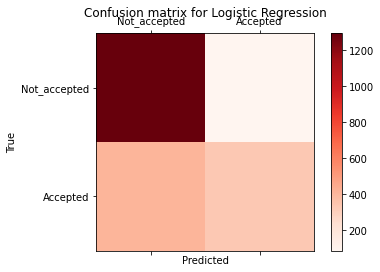

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

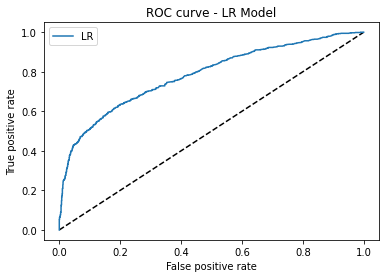

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7829770639014562

### Feature selection

In [ ]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


interactions_1-10: -1.4876
interactions_>30: 0.9037
reviews_>30: 0.7894
interactions_21-30: 0.7412
rt_Shared room*guest_size_1: 0.6824
reviews_21-30: 0.671
reviews_11-20: 0.6104
interactions_1-10*lead_time_>90d: -0.61
reviews_0: -0.5685
contact_me: 0.5346
contact_me*lead_time_1-30d: -0.4329
interactions_1-10*days_of_stay_1-5d: -0.4252
lead_time_>90d: -0.3469
contact_me*lead_time_>90d: 0.3443
past_booker*interactions_1-10: -0.2532
interactions_11-20*lead_time_>90d: -0.2424
interactions_1-10*days_of_stay_6-10d: -0.236
interactions_11-20*days_of_stay_1-5d: 0.2351
past_booker*interactions_11-20: 0.2239
days_of_stay_>15d: -0.2098
message_length_151-300*days_of_stay_1-5d: 0.2083
past_booker: 0.1368
rt_Private room: 0.0871
message_length_301-450: 0.073
rt_Entire_home/apt*guest_size_3-4: 0.0701
message_length_151-300*lead_time_>90d: -0.0618
interactions_1-10*message_length_151-300: -0.0523
contact_me*guest_size_1: -0.0441
lead_time_31-60d: 0.044
rt_Entire_home/apt*guest_size_5-6: -0.0437
messa

interactions, reviews, lead_time, channel(contact_me), days_of_stay, message_length, room_type*guest_size are the important features according to logistic regression model for binned numerical features 

## Final model (logistic regression with binned important features )

* RF model results: **interactions**, **reviews**, **reply_t**, **lead_time**, **message_length**, **days_of_stay**, **channel**, **guest_size** are the most important features

* Logistic regression model with numerical features: **interactions**, **reviews**, **lead_time**, **reply_t**, **days_of_stay**, **guest size**, room type, user_stage are important features 

* Logistic regression model fore binned numerical features: **interactions**, **reviews**, **lead_time**, **channel(contact_me)**, **days_of_stay**, **message_length**, **room_type*guest_size** are the most important features

RF model has the best performance(AUC score: 0.86), but in order to see the interactions between features more clearly, I would still use logistic regression model with binned numerical features(AUC score: 0.77) as the final model

In [ ]:
# Check what features are included
replied_inquiries = replied_inquiries_df.copy()
replied_inquiries = replied_inquiries[['total_interactions', 'total_reviews', 'lead_time', 'days_of_stay', 'reply_t', 'message_length', 'guest_size', 'rt_Entire_home/apt', 'rt_Private room', 'rt_Shared room', 'contact_me', 'accepted']]

replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_interactions  14129 non-null  int64  
 1   total_reviews       14129 non-null  float64
 2   lead_time           14129 non-null  int64  
 3   days_of_stay        14129 non-null  int64  
 4   reply_t             14129 non-null  float64
 5   message_length      14129 non-null  float64
 6   guest_size          14129 non-null  float64
 7   rt_Entire_home/apt  14129 non-null  int64  
 8   rt_Private room     14129 non-null  int64  
 9   rt_Shared room      14129 non-null  int64  
 10  contact_me          14129 non-null  int64  
 11  accepted            14129 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 1.3 MB


### Feature Preprocessing

#### Feature encoding

In [ ]:
# Binning interactions
interaction = [0,10,20,30,1000]
interaction_range = ['1-10','11-20','21-30','>30']
interactions_bin = pd.cut(replied_inquiries['total_interactions'], bins = interaction, labels= interaction_range)
replied_inquiries['interactions'] = interactions_bin

# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(replied_inquiries['total_reviews'], bins = review, labels=review_range)
replied_inquiries['reviews'] = reviews_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(replied_inquiries['lead_time'], bins = lead, labels=lead_range)
replied_inquiries['lead_time'] = lead_bin

# Binning days_of_stay
stay = [-1,5,10,15,1000]
stay_range = ['1-5d','6-10d','11-15d','>15d']
stay_bin = pd.cut(replied_inquiries['days_of_stay'], bins = stay, labels=stay_range)
replied_inquiries['days_of_stay'] = stay_bin

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(replied_inquiries['message_length'], bins = length, labels=length_range)
replied_inquiries['message_length'] = length_bin

# Binning guest size
size = [-1,1,2,4,6,30]
size_range = ['1','2','3-4','5-6','>6']
size_bin = pd.cut(replied_inquiries['guest_size'], bins = size, labels=size_range)
replied_inquiries['guest_size'] = size_bin

In [ ]:
# generate binary values using get_dummies
replied_inquiries = pd.get_dummies(replied_inquiries, columns=["interactions", "reviews", "lead_time", "days_of_stay", "message_length", "guest_size"] )

In [ ]:
# Drop columns not to be used
replied_inquiries = replied_inquiries.drop(['total_interactions', 'total_reviews'], axis = 1)

In [ ]:
replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   reply_t                 14129 non-null  float64
 1   rt_Entire_home/apt      14129 non-null  int64  
 2   rt_Private room         14129 non-null  int64  
 3   rt_Shared room          14129 non-null  int64  
 4   contact_me              14129 non-null  int64  
 5   accepted                14129 non-null  int64  
 6   interactions_1-10       14129 non-null  uint8  
 7   interactions_11-20      14129 non-null  uint8  
 8   interactions_21-30      14129 non-null  uint8  
 9   interactions_>30        14129 non-null  uint8  
 10  reviews_0               14129 non-null  uint8  
 11  reviews_1-10            14129 non-null  uint8  
 12  reviews_11-20           14129 non-null  uint8  
 13  reviews_21-30           14129 non-null  uint8  
 14  reviews_>30             14129 non-null

#### Interaction features

Creat interaction features to discover combined effects of independent variables

In [ ]:
# Interaction features

room_types = replied_inquiries.columns[1:4]
interactions = replied_inquiries.columns[6:10]
reviews = replied_inquiries.columns[10:15]
lead_times = replied_inquiries.columns[15:19]
stays = replied_inquiries.columns[19:23]
message_lengths = replied_inquiries.columns[23:27]
guest_sizes = replied_inquiries.columns[27:32]

# Lead_time * interaction 
for i in lead_times:
  for j in interactions:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Days_of_stay * Interaction 
for i in stays:
  for j in interactions:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Channel * lead_time
for i in lead_times:
  replied_inquiries['contact_me'+'*'+i] = replied_inquiries['contact_me'] * replied_inquiries[i]

# Lead_time * message_length
for i in lead_times:
  for j in message_lengths:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]

# Guest_size * room_type 
for i in guest_sizes:
  for j in room_types:
    replied_inquiries[i+'*'+j] = replied_inquiries[i] * replied_inquiries[j]


In [ ]:
replied_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14129 entries, 0 to 14128
Data columns (total 99 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   reply_t                                  14129 non-null  float64
 1   rt_Entire_home/apt                       14129 non-null  int64  
 2   rt_Private room                          14129 non-null  int64  
 3   rt_Shared room                           14129 non-null  int64  
 4   contact_me                               14129 non-null  int64  
 5   accepted                                 14129 non-null  int64  
 6   interactions_1-10                        14129 non-null  uint8  
 7   interactions_11-20                       14129 non-null  uint8  
 8   interactions_21-30                       14129 non-null  uint8  
 9   interactions_>30                         14129 non-null  uint8  
 10  reviews_0                                14129

#### Feature scaling

In [ ]:
# Scale reply_t (MinMax scaling)
sc_scale = preprocessing.MinMaxScaler().fit(replied_inquiries[['reply_t']])
replied_inquiries[['reply_t']] = sc_scale.transform(replied_inquiries[['reply_t']])


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = replied_inquiries.drop(['accepted'], axis = 1)
y = replied_inquiries['accepted']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    'penalty':['l2'],
    'C':np.logspace (-3, -0.2, num=50)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.001     , 0.00114062, 0...
       0.02682696, 0.0305995 , 0.03490255, 0.03981072, 0.0454091 ,
       0.05179475, 0.05907838, 0.06738627, 0.07686246, 0.08767124,
       0.1       , 0.11406249, 0.13010252, 0.14839818, 0.16926666,
       0.19306977, 0.22022019, 0.25118864, 0.28651203, 0.32680276,
       0.37275937,

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.757
Best parameters set:
	C: 0.08767123872968682
	penalty: 'l2'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_accepted','Accepted']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[1291,   88],
       [ 412,  329]])

Logistic Regression
Accuracy is: 0.764
precision is: 0.789
recall is: 0.444


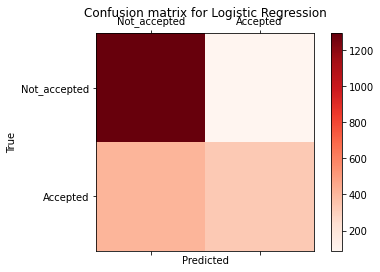

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

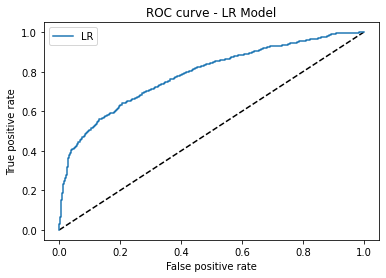

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7855200281061889

### Results interpretation

In [ ]:
# Store the coef for results interpretation
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


interactions_1-10: -1.2413
reviews_0: -0.8786
lead_time_>90d*interactions_1-10: -0.6769
interactions_>30: 0.6351
days_of_stay_1-5d*interactions_1-10: -0.5989
interactions_21-30: 0.5396
contact_me*lead_time_>90d: 0.5028
guest_size_1*rt_Shared room: 0.4907
reviews_>30: 0.4812
contact_me: 0.4304
days_of_stay_6-10d*interactions_1-10: -0.4006
days_of_stay_>15d*interactions_>30: 0.3974
guest_size_3-4*rt_Shared room: -0.3974
reviews_21-30: 0.394
contact_me*lead_time_1-30d: -0.3753
reviews_11-20: 0.3172
lead_time_>90d: -0.3171
reviews_1-10: -0.3133
days_of_stay_11-15d*interactions_21-30: 0.305
days_of_stay_1-5d*interactions_11-20: 0.2947
lead_time_>90d*interactions_21-30: 0.2864
days_of_stay_6-10d*interactions_21-30: 0.2638
lead_time_>90d*interactions_>30: 0.2576
reply_t: -0.2506
days_of_stay_>15d*interactions_21-30: -0.2449
contact_me*lead_time_61-90d: 0.2343
lead_time_61-90d*interactions_1-10: -0.2172
lead_time_31-60d*interactions_1-10: -0.2162
days_of_stay_1-5d*interactions_21-30: 0.2158
da

In [ ]:
res = res.set_index('Feature')

In [ ]:
 print('reply_t: ' + str(res.Coef.loc['reply_t'])) 

reply_t: -0.2506



Inquiries with shorter reply times are more likely to be accepted 

In [ ]:
for i in list(interactions):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(reviews):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(lead_times):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(stays):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(message_lengths):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(guest_sizes):
  print(i + ": " + str(res.Coef.loc[i]))

interactions_1-10: -1.2413
interactions_11-20: 0.067
interactions_21-30: 0.5396
interactions_>30: 0.6351
reviews_0: -0.8786
reviews_1-10: -0.3133
reviews_11-20: 0.3172
reviews_21-30: 0.394
reviews_>30: 0.4812
lead_time_1-30d: 0.1015
lead_time_31-60d: 0.1707
lead_time_61-90d: 0.0453
lead_time_>90d: -0.3171
days_of_stay_1-5d: 0.1123
days_of_stay_6-10d: 0.0175
days_of_stay_11-15d: 0.0599
days_of_stay_>15d: -0.1893
message_length_0-150: -0.0335
message_length_151-300: 0.0398
message_length_301-450: 0.0624
message_length_>450: -0.0682
guest_size_1: 0.1755
guest_size_2: 0.013
guest_size_3-4: -0.1228
guest_size_5-6: -0.0135
guest_size_>6: -0.0516


*   More than 20 interactions significantly increases the probability of acceptance, and having less than 10 interactions decreases it
*   Hosts whose listings have more than 10 reviews are more likely to accept the inquiries than those whose listings have less than 10 reviews
*   Inquiries made 31-60 days before check-in most likely to be accepted, and inquiries made more than 90 days before check-in are likely to be rejected
*   Inquiries for 11-15 days are most likely to be accepted, but inquiries for more than 15 days are more likely to be rejected
*   Inquiries with message between 150 and 450 characters are more likely to be accepted
*   Inquiries for single guest are most likely to be accepted, and inquirie for more than 2 guests are less likely to be booked


In [ ]:
for i in list(lead_times):
  for j in list(interactions):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

lead_time_1-30d*interactions_1-10: -0.131
lead_time_1-30d*interactions_11-20: 0.0241
lead_time_1-30d*interactions_21-30: 0.0601
lead_time_1-30d*interactions_>30: 0.1483
lead_time_31-60d*interactions_1-10: -0.2162
lead_time_31-60d*interactions_11-20: 0.1289
lead_time_31-60d*interactions_21-30: 0.0856
lead_time_31-60d*interactions_>30: 0.1724
lead_time_61-90d*interactions_1-10: -0.2172
lead_time_61-90d*interactions_11-20: 0.0981
lead_time_61-90d*interactions_21-30: 0.1076
lead_time_61-90d*interactions_>30: 0.0569
lead_time_>90d*interactions_1-10: -0.6769
lead_time_>90d*interactions_11-20: -0.1841
lead_time_>90d*interactions_21-30: 0.2864
lead_time_>90d*interactions_>30: 0.2576


Having more than 10 interactions drives up the probability of acceptance from negative to positive across all lead times

For inquiries with lead time >90 days, need more than 20 interactions to drive accpetance


In [ ]:
for i in list(stays):
  for j in list(interactions):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

days_of_stay_1-5d*interactions_1-10: -0.5989
days_of_stay_1-5d*interactions_11-20: 0.2947
days_of_stay_1-5d*interactions_21-30: 0.2158
days_of_stay_1-5d*interactions_>30: 0.2008
days_of_stay_6-10d*interactions_1-10: -0.4006
days_of_stay_6-10d*interactions_11-20: 0.0602
days_of_stay_6-10d*interactions_21-30: 0.2638
days_of_stay_6-10d*interactions_>30: 0.0942
days_of_stay_11-15d*interactions_1-10: -0.1018
days_of_stay_11-15d*interactions_11-20: -0.0859
days_of_stay_11-15d*interactions_21-30: 0.305
days_of_stay_11-15d*interactions_>30: -0.0573
days_of_stay_>15d*interactions_1-10: -0.14
days_of_stay_>15d*interactions_11-20: -0.2019
days_of_stay_>15d*interactions_21-30: -0.2449
days_of_stay_>15d*interactions_>30: 0.3974


Having less than 10 interactions decreases the probability of acceptance across all lengths of stay

When stay <= 5 days, interaction between 11 - 20 benefits acceptance the most

When stay between 6 - 15 days, interaction between 21- - 30 benefits acceptance the most

When stay > 15 days, need more than 30 interactions to drive acceptance



In [ ]:
print('contact_me: ' + str(res.Coef.loc['contact_me']))
for i in list(lead_times):
  print('contact_me*'+ i + ": " + str(res.Coef.loc['contact_me*'+ i]))

contact_me: 0.2921
contact_me*lead_time_1-30d: -0.2821
contact_me*lead_time_31-60d: 0.0746
contact_me*lead_time_61-90d: 0.1576
contact_me*lead_time_>90d: 0.3419


Inquiries that are replied in contact me channel are more likely to be accepted.

Inquiries made within 30 days before checkin are more likely to be accepted in Book it channel

Inquiries made more than 30 days before checkin are more likely to be accepted in Contact Me channel



In [ ]:
for i in list(lead_times):
  for j in list(message_lengths):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

lead_time_1-30d*message_length_0-150: 0.0042
lead_time_1-30d*message_length_151-300: 0.0605
lead_time_1-30d*message_length_301-450: 0.0176
lead_time_1-30d*message_length_>450: 0.0192
lead_time_31-60d*message_length_0-150: 0.0613
lead_time_31-60d*message_length_151-300: 0.0487
lead_time_31-60d*message_length_301-450: 0.0965
lead_time_31-60d*message_length_>450: -0.0358
lead_time_61-90d*message_length_0-150: -0.0662
lead_time_61-90d*message_length_151-300: 0.0971
lead_time_61-90d*message_length_301-450: 0.006
lead_time_61-90d*message_length_>450: 0.0085
lead_time_>90d*message_length_0-150: -0.0328
lead_time_>90d*message_length_151-300: -0.1666
lead_time_>90d*message_length_301-450: -0.0577
lead_time_>90d*message_length_>450: -0.06


When lead time between 31 - 60 days, sending long messages(> 450 char) drags down acceptance rate

When lead time between 61 - 90 days, sending short messages(< 150 char) drags down acceptance rate

In [ ]:
for i in list(guest_sizes):
  for j in list(room_types):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

guest_size_1*rt_Entire_home/apt: -0.1985
guest_size_1*rt_Private room: -0.1167
guest_size_1*rt_Shared room: 0.4907
guest_size_2*rt_Entire_home/apt: -0.0504
guest_size_2*rt_Private room: 0.0454
guest_size_2*rt_Shared room: 0.018
guest_size_3-4*rt_Entire_home/apt: 0.1826
guest_size_3-4*rt_Private room: 0.092
guest_size_3-4*rt_Shared room: -0.3974
guest_size_5-6*rt_Entire_home/apt: -0.0877
guest_size_5-6*rt_Private room: 0.0457
guest_size_5-6*rt_Shared room: 0.0285
guest_size_>6*rt_Entire_home/apt: 0.1019
guest_size_>6*rt_Private room: -0.0843
guest_size_>6*rt_Shared room: -0.0692


When guest size = 1, inquiries for a shared room are most likely to be accepted

When guest size = 2, inquiries for a private room are most likely to be accepted

When guest size between 3 - 4 or > 6, inquiries for an entire_home/apt are most likely to be accepted

When guest size between 5 - 6, inquiries for an entire_home/apt are less likely to be accepted




In [ ]:
|from google.colab import files

res.to_csv('mod2_res.csv')
files.download('mod2_res.csv')

# Accepted inquiries

The goal in this section is to find **what drives guests' confirmation for booking** for accepted inquiries in Contact Me channel using ML models.

In [ ]:
# check the propotion of replied = 1
y = accepted_inquiries_df['booked']
print(y.sum() / y.shape * 100)

[16.71503192]


The number of inquiries that were confirmed(booked) by guests are less than those weren't

## Random forest 

In [ ]:
# Check what features are included
accepted_inquiries = accepted_inquiries_df.copy()
accepted_inquiries = accepted_inquiries.drop(columns=['Unnamed: 0'])

accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          5169 non-null   float64
 1   total_interactions  5169 non-null   int64  
 2   message_length      5169 non-null   float64
 3   total_reviews       5169 non-null   float64
 4   lead_time           5169 non-null   int64  
 5   days_of_stay        5169 non-null   int64  
 6   accept_t            5169 non-null   float64
 7   booked              5169 non-null   int64  
 8   past_booker         5169 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 363.6 KB


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = accepted_inquiries.drop(['booked'], axis = 1)
y = accepted_inquiries['booked']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    #'n_estimators' : np.arange(75,85)
    'n_estimators' : [60, 70, 80],
    'max_depth' : [5, 8, 10, 12]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

# best random forest
best_RF_model = Grid_RF.best_estimator_

Best score: 0.896
Best parameters set:
	max_depth: 8
	n_estimators: 60


### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_booked','Booked']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_RF_model.predict(model_test_x))

array([[621,  25],
       [ 56,  74]])

Logistic Regression
Accuracy is: 0.896
precision is: 0.747
recall is: 0.569


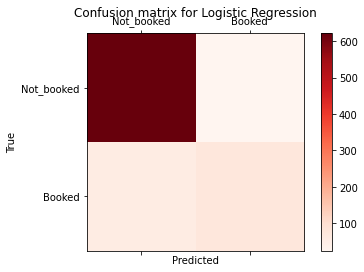

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_RF_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(model_test_x)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(model_test_y, y_pred_rf)

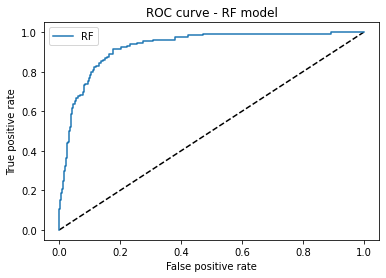

In [ ]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.9265182186234818

### Feature selection

In [ ]:
# check feature importance of random forest for feature selection
forest = best_RF_model
forest.fit(model_train_x, model_train_y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), model_train_x.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_interactions: 0.6413
message_length: 0.0824
accept_t: 0.0682
lead_time: 0.0627
total_reviews: 0.0531
days_of_stay: 0.0459
guest_size: 0.0276
past_booker: 0.0187


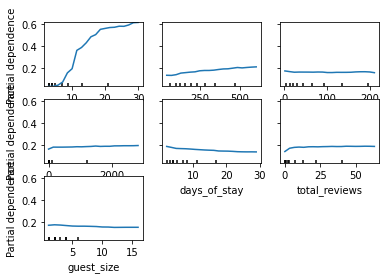

In [ ]:
from sklearn.inspection import plot_partial_dependence

features = ['total_interactions', 'message_length', 'lead_time', 'accept_t', 'days_of_stay', 'total_reviews','guest_size']
plot_partial_dependence(best_RF_model, model_train_x, features,
                        n_jobs=4, grid_resolution=20)

Interactions, message_length, accept_t, lead_time, reviews, and days_of_stay are the important features according to RF model results

## Logistic regression (numerical)

In [ ]:
# Check what features are included
accepted_inquiries = accepted_inquiries_df.copy()
accepted_inquiries = accepted_inquiries.drop(columns=['Unnamed: 0'])

accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          5169 non-null   float64
 1   total_interactions  5169 non-null   int64  
 2   message_length      5169 non-null   float64
 3   total_reviews       5169 non-null   float64
 4   lead_time           5169 non-null   int64  
 5   days_of_stay        5169 non-null   int64  
 6   accept_t            5169 non-null   float64
 7   booked              5169 non-null   int64  
 8   past_booker         5169 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 363.6 KB


### Feature Preprocessing

#### Interaction features

In [ ]:
accepted_inquiries['interaction*message_length'] = accepted_inquiries['total_interactions'] * accepted_inquiries['message_length']
accepted_inquiries['interaction*lead_time'] = accepted_inquiries['total_interactions'] * accepted_inquiries['lead_time']
accepted_inquiries['interaction*days_of_stay'] = accepted_inquiries['total_interactions'] * accepted_inquiries['days_of_stay']
accepted_inquiries['interaction*past_booker'] = accepted_inquiries['total_interactions'] * accepted_inquiries['past_booker']

accepted_inquiries['message_length*lead_time'] = accepted_inquiries['message_length'] * accepted_inquiries['lead_time']
accepted_inquiries['message_length*days_of_stay'] = accepted_inquiries['message_length'] * accepted_inquiries['days_of_stay']

accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   guest_size                   5169 non-null   float64
 1   total_interactions           5169 non-null   int64  
 2   message_length               5169 non-null   float64
 3   total_reviews                5169 non-null   float64
 4   lead_time                    5169 non-null   int64  
 5   days_of_stay                 5169 non-null   int64  
 6   accept_t                     5169 non-null   float64
 7   booked                       5169 non-null   int64  
 8   past_booker                  5169 non-null   int64  
 9   interaction*message_length   5169 non-null   float64
 10  interaction*lead_time        5169 non-null   int64  
 11  interaction*days_of_stay     5169 non-null   int64  
 12  interaction*past_booker      5169 non-null   int64  
 13  message_length*lea

#### Feature scaling

In [ ]:
from sklearn import preprocessing

scale_list = list(accepted_inquiries.columns)
scale_list.remove('booked')
scale_list.remove('past_booker')

# MinMax scaling
sc_scale = preprocessing.MinMaxScaler().fit(accepted_inquiries[scale_list])
accepted_inquiries[scale_list] = sc_scale.transform(accepted_inquiries[scale_list])


In [ ]:
accepted_inquiries.head(10)

,guest_size,total_interactions,message_length,total_reviews,lead_time,days_of_stay,accept_t,booked,past_booker,interaction*message_length,interaction*lead_time,interaction*days_of_stay,interaction*past_booker,message_length*lead_time,message_length*days_of_stay
0,0.067,0.008,0.106,0.063,0.026,0.003,0.000,0,0,0.011,0.003,0.000,0.000,0.011,0.002
1,0.333,0.039,0.015,0.000,0.083,0.020,0.016,0,1,0.004,0.024,0.005,0.054,0.005,0.001
2,0.200,0.023,0.036,0.000,0.019,0.011,0.006,0,0,0.006,0.004,0.002,0.000,0.003,0.002
3,0.333,0.039,0.217,0.060,0.010,0.020,0.000,0,0,0.052,0.003,0.005,0.000,0.009,0.017
4,0.000,0.008,0.047,0.004,0.041,0.497,0.000,0,0,0.005,0.005,0.051,0.000,0.008,0.084
5,0.200,0.039,0.102,0.011,0.265,0.017,0.000,0,0,0.025,0.075,0.004,0.000,0.108,0.007
6,0.067,0.039,0.102,0.052,0.167,0.056,0.000,0,1,0.025,0.047,0.014,0.054,0.067,0.021
7,0.067,0.031,0.360,0.201,0.286,0.170,0.002,0,0,0.075,0.069,0.035,0.000,0.411,0.225
8,1.000,0.000,0.053,0.000,0.012,0.006,0.000,0,0,0.004,0.001,0.000,0.000,0.003,0.002
9,0.200,0.008,0.188,0.007,0.252,0.014,0.000,0,1,0.019,0.030,0.002,0.023,0.188,0.011


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = accepted_inquiries.drop(['booked'], axis = 1)
y = accepted_inquiries['booked']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    # ('l1', 'l2')
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':np.logspace (-0.5, 1, num=50)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 0.31622777,  0.33932...
        1.84206997,  1.97659807,  2.12095089,  2.27584593,  2.44205309,
        2.62039853,  2.8117687 ,  3.01711481,  3.23745754,  3.47389211,
        3.72759372,  3.9998234 ,  4.29193426,  4.60537826,  4.94171336,
        5.30261134,  5.68986603,  6.1054023 ,  6.55128557,  7.02973212,
  

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.883
Best parameters set:
	C: 4.941713361323833
	penalty: 'l1'
	solver: 'liblinear'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_booked','Booked']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[627,  19],
       [ 74,  56]])

Logistic Regression
Accuracy is: 0.880
precision is: 0.747
recall is: 0.431


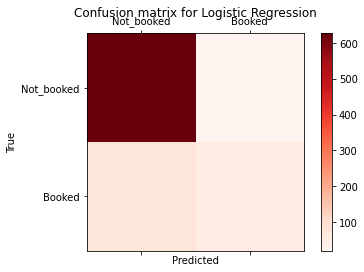

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

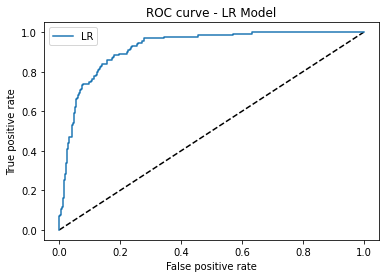

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.9219933317456537

### Feature selection

In [ ]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


interaction*message_length: 13.3692
message_length*days_of_stay: -11.0856
total_interactions: 11.062
interaction*days_of_stay: -7.3298
interaction*lead_time: 5.8088
interaction*past_booker: 5.1107
days_of_stay: -4.2462
lead_time: -3.099
total_reviews: 1.359
message_length*lead_time: -1.2066
accept_t: 1.181
guest_size: -1.1264
past_booker: 0.2314
message_length: -0.1063


Interactions, days_of_stay, lead_time, reviews, accept_t, guest_size, user_stage are important features according to logistic regression models with numerical features.


## Logistic regression (binned numerical)

In [ ]:
# Check what features are included
accepted_inquiries = accepted_inquiries_df.copy()
accepted_inquiries = accepted_inquiries.drop(columns=['Unnamed: 0'])

accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   guest_size          5169 non-null   float64
 1   total_interactions  5169 non-null   int64  
 2   message_length      5169 non-null   float64
 3   total_reviews       5169 non-null   float64
 4   lead_time           5169 non-null   int64  
 5   days_of_stay        5169 non-null   int64  
 6   accept_t            5169 non-null   float64
 7   booked              5169 non-null   int64  
 8   past_booker         5169 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 363.6 KB


### Feature Preprocessing

#### Feature encoding

In order to see the nuances of some features' impact, I decided to create buckets for numerical variables including:
*   Interaction
*   Review
*   Lead time
*   Days of stay
*   Message length
*   Guest size



And these bins will be used to create interactive features as well




In [ ]:
# Binning interactions
interaction = [0,10,20,30,1000]
interaction_range = ['1-10','11-20','21-30','>30']
interactions_bin = pd.cut(accepted_inquiries['total_interactions'], bins = interaction, labels= interaction_range)
accepted_inquiries['interactions'] = interactions_bin

# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(accepted_inquiries['total_reviews'], bins = review, labels=review_range)
accepted_inquiries['reviews'] = reviews_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(accepted_inquiries['lead_time'], bins = lead, labels=lead_range)
accepted_inquiries['lead_time'] = lead_bin

# Binning days_of_stay
stay = [-1,5,10,15,1000]
stay_range = ['1-5d','6-10d','11-15d','>15d']
stay_bin = pd.cut(accepted_inquiries['days_of_stay'], bins = stay, labels=stay_range)
accepted_inquiries['days_of_stay'] = stay_bin

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(accepted_inquiries['message_length'], bins = length, labels=length_range)
accepted_inquiries['message_length'] = length_bin

# Binning guest size
size = [-1,1,2,4,6,30]
size_range = ['1','2','3-4','5-6','>6']
size_bin = pd.cut(accepted_inquiries['guest_size'], bins = size, labels=size_range)
accepted_inquiries['guest_size'] = size_bin

In [ ]:
# generate binary values using get_dummies
accepted_inquiries = pd.get_dummies(accepted_inquiries, columns=["interactions", "reviews", "lead_time", "days_of_stay", "message_length", "guest_size"] )

In [ ]:
# Drop columns not to be used
accepted_inquiries = accepted_inquiries.drop(['total_interactions', 'total_reviews'], axis = 1)

In [ ]:
accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accept_t                5169 non-null   float64
 1   booked                  5169 non-null   int64  
 2   past_booker             5169 non-null   int64  
 3   interactions_1-10       5169 non-null   uint8  
 4   interactions_11-20      5169 non-null   uint8  
 5   interactions_21-30      5169 non-null   uint8  
 6   interactions_>30        5169 non-null   uint8  
 7   reviews_0               5169 non-null   uint8  
 8   reviews_1-10            5169 non-null   uint8  
 9   reviews_11-20           5169 non-null   uint8  
 10  reviews_21-30           5169 non-null   uint8  
 11  reviews_>30             5169 non-null   uint8  
 12  lead_time_1-30d         5169 non-null   uint8  
 13  lead_time_31-60d        5169 non-null   uint8  
 14  lead_time_61-90d        5169 non-null   

#### Interaction features

Creat interaction features to discover combined effects of independent variables

In [ ]:
# Interaction features

interactions = accepted_inquiries.columns[3:7]
reviews = accepted_inquiries.columns[7:12]
lead_times = accepted_inquiries.columns[12:16]
stays = accepted_inquiries.columns[16:20]
message_lengths = accepted_inquiries.columns[20:24]
guest_sizes = accepted_inquiries.columns[24:29]

# Interaction * message length
for i in interactions:
  for j in message_lengths:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]

# Interaction * lead time
for i in interactions:
  for j in lead_times:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]

# Interaction * days of stay
for i in interactions:
  for j in stays:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]

# User stage + interactions
for i in interactions:
    accepted_inquiries['past_booker'+'*'+i] = accepted_inquiries['past_booker'] * accepted_inquiries[i]

# Message length * days of stay
for i in message_lengths:
  for j in stays:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]

# Message length * lead time
for i in message_lengths:
  for j in lead_times:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]


In [ ]:
accepted_inquiries.head(10)

,accept_t,booked,past_booker,interactions_1-10,interactions_11-20,interactions_21-30,interactions_>30,reviews_0,reviews_1-10,reviews_11-20,reviews_21-30,reviews_>30,lead_time_1-30d,lead_time_31-60d,lead_time_61-90d,lead_time_>90d,days_of_stay_1-5d,days_of_stay_6-10d,days_of_stay_11-15d,days_of_stay_>15d,message_length_0-150,message_length_151-300,message_length_301-450,message_length_>450,guest_size_1,guest_size_2,guest_size_3-4,guest_size_5-6,guest_size_>6,interactions_1-10*message_length_0-150,interactions_1-10*message_length_151-300,interactions_1-10*message_length_301-450,interactions_1-10*message_length_>450,interactions_11-20*message_length_0-150,interactions_11-20*message_length_151-300,interactions_11-20*message_length_301-450,interactions_11-20*message_length_>450,interactions_21-30*message_length_0-150,interactions_21-30*message_length_151-300,interactions_21-30*message_length_301-450,...,interactions_>30*days_of_stay_1-5d,interactions_>30*days_of_stay_6-10d,interactions_>30*days_of_stay_11-15d,interactions_>30*days_of_stay_>15d,past_booker*interactions_1-10,past_booker*interactions_11-20,past_booker*interactions_21-30,past_booker*interactions_>30,message_length_0-150*days_of_stay_1-5d,message_length_0-150*days_of_stay_6-10d,message_length_0-150*days_of_stay_11-15d,message_length_0-150*days_of_stay_>15d,message_length_151-300*days_of_stay_1-5d,message_length_151-300*days_of_stay_6-10d,message_length_151-300*days_of_stay_11-15d,message_length_151-300*days_of_stay_>15d,message_length_301-450*days_of_stay_1-5d,message_length_301-450*days_of_stay_6-10d,message_length_301-450*days_of_stay_11-15d,message_length_301-450*days_of_stay_>15d,message_length_>450*days_of_stay_1-5d,message_length_>450*days_of_stay_6-10d,message_length_>450*days_of_stay_11-15d,message_length_>450*days_of_stay_>15d,message_length_0-150*lead_time_1-30d,message_length_0-150*lead_time_31-60d,message_length_0-150*lead_time_61-90d,message_length_0-150*lead_time_>90d,message_length_151-300*lead_time_1-30d,message_length_151-300*lead_time_31-60d,message_length_151-300*lead_time_61-90d,message_length_151-300*lead_time_>90d,message_length_301-450*lead_time_1-30d,message_length_301-450*lead_time_31-60d,message_length_301-450*lead_time_61-90d,message_length_301-450*lead_time_>90d,message_length_>450*lead_time_1-30d,message_length_>450*lead_time_31-60d,message_length_>450*lead_time_61-90d,message_length_>450*lead_time_>90d
0,0.000,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3379.417,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1311.383,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.267,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.250,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,1.583,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,455.417,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0.000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.167,0,1,1,0,0,0,0,1,0,0,0,

#### Feature scaling

In [ ]:
# Scale accept_t (MinMax scaling)
sc_scale = preprocessing.MinMaxScaler().fit(accepted_inquiries[['accept_t']])
accepted_inquiries[['accept_t']] = sc_scale.transform(accepted_inquiries[['accept_t']])


In [ ]:
accepted_inquiries.head(10)

,accept_t,booked,past_booker,interactions_1-10,interactions_11-20,interactions_21-30,interactions_>30,reviews_0,reviews_1-10,reviews_11-20,reviews_21-30,reviews_>30,lead_time_1-30d,lead_time_31-60d,lead_time_61-90d,lead_time_>90d,days_of_stay_1-5d,days_of_stay_6-10d,days_of_stay_11-15d,days_of_stay_>15d,message_length_0-150,message_length_151-300,message_length_301-450,message_length_>450,guest_size_1,guest_size_2,guest_size_3-4,guest_size_5-6,guest_size_>6,interactions_1-10*message_length_0-150,interactions_1-10*message_length_151-300,interactions_1-10*message_length_301-450,interactions_1-10*message_length_>450,interactions_11-20*message_length_0-150,interactions_11-20*message_length_151-300,interactions_11-20*message_length_301-450,interactions_11-20*message_length_>450,interactions_21-30*message_length_0-150,interactions_21-30*message_length_151-300,interactions_21-30*message_length_301-450,...,interactions_>30*days_of_stay_1-5d,interactions_>30*days_of_stay_6-10d,interactions_>30*days_of_stay_11-15d,interactions_>30*days_of_stay_>15d,past_booker*interactions_1-10,past_booker*interactions_11-20,past_booker*interactions_21-30,past_booker*interactions_>30,message_length_0-150*days_of_stay_1-5d,message_length_0-150*days_of_stay_6-10d,message_length_0-150*days_of_stay_11-15d,message_length_0-150*days_of_stay_>15d,message_length_151-300*days_of_stay_1-5d,message_length_151-300*days_of_stay_6-10d,message_length_151-300*days_of_stay_11-15d,message_length_151-300*days_of_stay_>15d,message_length_301-450*days_of_stay_1-5d,message_length_301-450*days_of_stay_6-10d,message_length_301-450*days_of_stay_11-15d,message_length_301-450*days_of_stay_>15d,message_length_>450*days_of_stay_1-5d,message_length_>450*days_of_stay_6-10d,message_length_>450*days_of_stay_11-15d,message_length_>450*days_of_stay_>15d,message_length_0-150*lead_time_1-30d,message_length_0-150*lead_time_31-60d,message_length_0-150*lead_time_61-90d,message_length_0-150*lead_time_>90d,message_length_151-300*lead_time_1-30d,message_length_151-300*lead_time_31-60d,message_length_151-300*lead_time_61-90d,message_length_151-300*lead_time_>90d,message_length_301-450*lead_time_1-30d,message_length_301-450*lead_time_31-60d,message_length_301-450*lead_time_61-90d,message_length_301-450*lead_time_>90d,message_length_>450*lead_time_1-30d,message_length_>450*lead_time_31-60d,message_length_>450*lead_time_61-90d,message_length_>450*lead_time_>90d
0,0.000,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.016,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.006,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.000,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,0.000,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0.002,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0.000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0.000,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,

#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = accepted_inquiries.drop(['booked'], axis = 1)
y = accepted_inquiries['booked']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    # ('l1', 'l2')
    'penalty':['l1'],
    'solver':['liblinear'],
    'C':np.logspace (-1.5, -0.8, num=50)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.03162278, 0.03268...
       0.07196857, 0.07437527, 0.07686246, 0.07943282, 0.08208914,
       0.08483429, 0.08767124, 0.09060306, 0.09363292, 0.09676411,
       0.1       , 0.10334411, 0.10680004, 0.11037155, 0.11406249,
       0.11787686, 0.12181879, 0.12589254, 0.13010252, 0.13445329,
       0.13894955, 0.143

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.885
Best parameters set:
	C: 0.08208914159638253
	penalty: 'l1'
	solver: 'liblinear'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_booked','Booked']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[614,  32],
       [ 55,  75]])

Logistic Regression
Accuracy is: 0.888
precision is: 0.701
recall is: 0.577


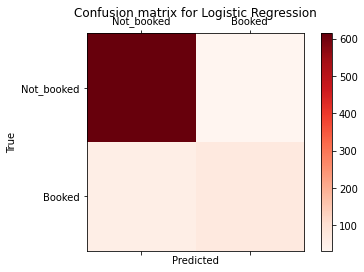

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

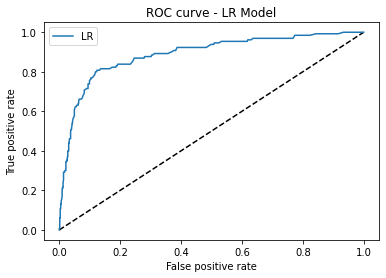

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8882769707073114

### Feature selection

In [ ]:
# Store the coef for feature selection
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


interactions_1-10: -3.013
interactions_>30: 0.877
interactions_21-30: 0.531
past_booker: 0.4857
message_length_0-150: -0.4795
days_of_stay_>15d: -0.4368
reviews_0: -0.4079
message_length_>450: 0.1992
guest_size_2: 0.1627
days_of_stay_1-5d: 0.1392
interactions_11-20: -0.1228
interactions_1-10*lead_time_>90d: -0.1022
interactions_1-10*message_length_151-300: -0.0356
reviews_>30: 0.0162
message_length_151-300*lead_time_1-30d: -0.0126
accept_t: 0.0
days_of_stay_11-15d: 0.0
days_of_stay_6-10d: 0.0
guest_size_1: 0.0
guest_size_3-4: 0.0
guest_size_5-6: 0.0
guest_size_>6: 0.0
interactions_1-10*days_of_stay_1-5d: 0.0
interactions_1-10*days_of_stay_11-15d: 0.0
interactions_1-10*days_of_stay_6-10d: 0.0
interactions_1-10*days_of_stay_>15d: 0.0
interactions_1-10*lead_time_1-30d: 0.0
interactions_1-10*lead_time_31-60d: 0.0
interactions_1-10*lead_time_61-90d: 0.0
interactions_1-10*message_length_0-150: 0.0
interactions_1-10*message_length_301-450: 0.0
interactions_1-10*message_length_>450: 0.0
intera

interactions, user_stage, message length, days_of_stay, reviews,guest_size are the most important features according to logistic regression model for binned numerical features 

## Final model (logistic regression with binned important features )

* RF model results: **Interactions**, **message_length**, **accept_t**, **lead_time**, **reviews**, and **days_of_stay** are the most important features

* Logistic regression model with numerical features: **Interactions**, **days_of_stay**, **lead_time**, **reviews**, **accept_t** and **user_stage** are important features 

* Logistic regression model fore binned numerical features:: **interactions**, **user_stage**, **message length**, **days_of_stay**, and **reviews** are the most important features



Logistic regression model with numerical features has the best performance(AUC score: 0.90), but in order to see the interactions between features more clearly, I would still use logistic regression model with binned numerical features(AUC score: 0.86) as the final model

In [ ]:
# Check what features are included
accepted_inquiries = accepted_inquiries_df.copy() 
accepted_inquiries = accepted_inquiries[['total_interactions', 'total_reviews', 'lead_time', 'days_of_stay', 'accept_t', 'message_length', 'past_booker', 'booked']]

accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_interactions  5169 non-null   int64  
 1   total_reviews       5169 non-null   float64
 2   lead_time           5169 non-null   int64  
 3   days_of_stay        5169 non-null   int64  
 4   accept_t            5169 non-null   float64
 5   message_length      5169 non-null   float64
 6   past_booker         5169 non-null   int64  
 7   booked              5169 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 323.2 KB


### Feature Preprocessing

#### Feature encoding

In [ ]:
# Binning interactions
interaction = [0,10,20,30,1000]
interaction_range = ['1-10','11-20','21-30','>30']
interactions_bin = pd.cut(accepted_inquiries['total_interactions'], bins = interaction, labels= interaction_range)
accepted_inquiries['interactions'] = interactions_bin

# Binning reviews
review = [-1,0,10,20,30,1000]
review_range = ['0','1-10','11-20','21-30','>30']
reviews_bin = pd.cut(accepted_inquiries['total_reviews'], bins = review, labels=review_range)
accepted_inquiries['reviews'] = reviews_bin

# Binning lead time
lead = [-1,30,60,90,1000]
lead_range = ['1-30d','31-60d','61-90d', '>90d']
lead_bin = pd.cut(accepted_inquiries['lead_time'], bins = lead, labels=lead_range)
accepted_inquiries['lead_time'] = lead_bin

# Binning days_of_stay
stay = [-1,5,10,15,1000]
stay_range = ['1-5d','6-10d','11-15d','>15d']
stay_bin = pd.cut(accepted_inquiries['days_of_stay'], bins = stay, labels=stay_range)
accepted_inquiries['days_of_stay'] = stay_bin

# Binning message_length
length = [-1,150,300,450,3000]
length_range = ['0-150','151-300','301-450','>450']
length_bin = pd.cut(accepted_inquiries['message_length'], bins = length, labels=length_range)
accepted_inquiries['message_length'] = length_bin


In [ ]:
# generate binary values using get_dummies 
accepted_inquiries = pd.get_dummies(accepted_inquiries, columns=["interactions", "reviews", "lead_time", "days_of_stay", "message_length"] )

In [ ]:
# Drop columns not to be used
accepted_inquiries = accepted_inquiries.drop(['total_interactions', 'total_reviews'], axis = 1)

In [ ]:
accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accept_t                5169 non-null   float64
 1   past_booker             5169 non-null   int64  
 2   booked                  5169 non-null   int64  
 3   interactions_1-10       5169 non-null   uint8  
 4   interactions_11-20      5169 non-null   uint8  
 5   interactions_21-30      5169 non-null   uint8  
 6   interactions_>30        5169 non-null   uint8  
 7   reviews_0               5169 non-null   uint8  
 8   reviews_1-10            5169 non-null   uint8  
 9   reviews_11-20           5169 non-null   uint8  
 10  reviews_21-30           5169 non-null   uint8  
 11  reviews_>30             5169 non-null   uint8  
 12  lead_time_1-30d         5169 non-null   uint8  
 13  lead_time_31-60d        5169 non-null   uint8  
 14  lead_time_61-90d        5169 non-null   

#### Interaction features

Creat interaction features to discover combined effects of independent variables

In [ ]:
# Interaction features

interactions = accepted_inquiries.columns[3:7]
reviews = accepted_inquiries.columns[7:12]
lead_times = accepted_inquiries.columns[12:16]
stays = accepted_inquiries.columns[16:20]
message_lengths = accepted_inquiries.columns[20:24]


# Lead_time * interaction 
for i in lead_times:
  for j in interactions:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]

# Message_length * interaction 
for i in message_lengths:
  for j in interactions:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]

# Lead_time * message_length
for i in lead_times:
  for j in message_lengths:
    accepted_inquiries[i+'*'+j] = accepted_inquiries[i] * accepted_inquiries[j]


In [ ]:
accepted_inquiries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 72 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   accept_t                                   5169 non-null   float64
 1   past_booker                                5169 non-null   int64  
 2   booked                                     5169 non-null   int64  
 3   interactions_1-10                          5169 non-null   uint8  
 4   interactions_11-20                         5169 non-null   uint8  
 5   interactions_21-30                         5169 non-null   uint8  
 6   interactions_>30                           5169 non-null   uint8  
 7   reviews_0                                  5169 non-null   uint8  
 8   reviews_1-10                               5169 non-null   uint8  
 9   reviews_11-20                              5169 non-null   uint8  
 10  reviews_21-30           

#### Feature scaling

In [ ]:
# Scale accept_t (MinMax scaling)
sc_scale = preprocessing.MinMaxScaler().fit(accepted_inquiries[['accept_t']])
accepted_inquiries[['accept_t']] = sc_scale.transform(accepted_inquiries[['accept_t']])


#### Split training and test data

In [ ]:
from sklearn.model_selection import train_test_split

X = accepted_inquiries.drop(['booked'], axis = 1)
y = accepted_inquiries['booked']

model_train_x, model_test_x, model_train_y, model_test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state = 3) 

### Train model and find optimal hypermarameters

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    # ('l1', 'l2')
    'penalty':['l2'],
    'C':np.logspace (-1.8, 2, num=100)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(model_train_x, model_train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.58489319e-02, 1.7...
       1.86512125e+01, 2.03746853e+01, 2.22574162e+01, 2.43141217e+01,
       2.65608778e+01, 2.90152464e+01, 3.16964118e+01, 3.46253315e+01,
       3.78248991e+01, 4.13201240e+01, 4.51383266e+01, 4.93093517e+01,
       5.38658021e+01, 5.88432931e+01, 6.42807312e+01, 7.02206179e+01,
       7

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.885
Best parameters set:
	C: 0.09282752422641029
	penalty: 'l2'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Model evaluation

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not_booked','Booked']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [ ]:
confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))

array([[617,  29],
       [ 60,  70]])

Logistic Regression
Accuracy is: 0.885
precision is: 0.707
recall is: 0.538


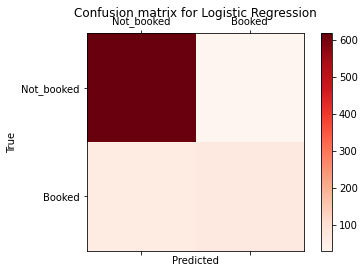

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(model_test_y, best_LR_model.predict(model_test_x))),
    #("Logistic Regression", confusion_matrix(yc_test,best_LR_model.predict(Xc_test))),
]

draw_confusion_matrices(confusion_matrices)

#### ROC & AUC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(model_test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(model_test_y, y_pred_lr)

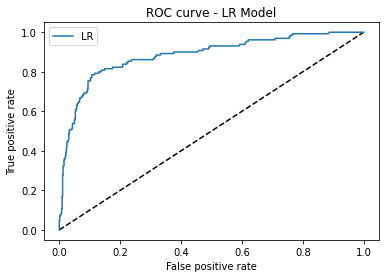

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8835853774708263

### Results interpretation

In [ ]:
# Store the coef for results interpretation
res = pd.DataFrame(columns=['Feature', 'Coef'])

for k,v in sorted(zip(map(lambda x: round(x, 4), best_LR_model.fit(model_train_x, model_train_y).coef_[0]), \
                      model_train_x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
    res = res.append({'Feature': v, 'Coef': k}, ignore_index=True)


interactions_1-10: -1.7255
interactions_>30: 0.9256
lead_time_>90d*interactions_1-10: -0.6576
interactions_21-30: 0.6503
past_booker: 0.5745
message_length_151-300*interactions_1-10: -0.5744
message_length_0-150*interactions_1-10: -0.5106
days_of_stay_>15d: -0.5073
message_length_151-300*interactions_>30: 0.4228
message_length_301-450*interactions_1-10: -0.4189
reviews_0: -0.4183
lead_time_1-30d*interactions_1-10: -0.3997
lead_time_>90d*interactions_>30: 0.3908
days_of_stay_1-5d: 0.355
lead_time_61-90d*interactions_1-10: -0.3507
message_length_0-150: -0.3504
message_length_301-450*interactions_21-30: 0.3285
lead_time_31-60d*interactions_1-10: -0.3174
message_length_>450*interactions_11-20: 0.2991
message_length_0-150*interactions_21-30: 0.2938
message_length_>450*interactions_>30: 0.2541
days_of_stay_6-10d: 0.2539
message_length_301-450*interactions_>30: 0.2461
lead_time_>90d*interactions_21-30: 0.241
message_length_>450: 0.2256
message_length_>450*interactions_1-10: -0.2216
lead_time_

In [ ]:
res = res.set_index('Feature')

In [ ]:
print('past_booker: ' + str(res.Coef.loc['past_booker'])) 
print('accept_t: ' + str(res.Coef.loc['accept_t'])) 


past_booker: 0.5745
accept_t: 0.0656


Past bookers are more likely to confirm bookings after the inquiries are accepted

Longer accept time slightly increases the probability of confirmation

In [ ]:
for i in list(interactions):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(reviews):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(stays):
  print(i + ": " + str(res.Coef.loc[i]))

for i in list(lead_times):
  print(i + ": " + str(res.Coef.loc[i]))

interactions_1-10: -1.7255
interactions_11-20: 0.1496
interactions_21-30: 0.6503
interactions_>30: 0.9256
reviews_0: -0.4183
reviews_1-10: 0.0352
reviews_11-20: 0.0887
reviews_21-30: 0.0832
reviews_>30: 0.2112
days_of_stay_1-5d: 0.355
days_of_stay_6-10d: 0.2539
days_of_stay_11-15d: -0.1016
days_of_stay_>15d: -0.5073
lead_time_1-30d: 0.0104
lead_time_31-60d: 0.0114
lead_time_61-90d: 0.0229
lead_time_>90d: -0.0447


*   More than 20 interactions significantly increases the probability of confirmation from hosts, and having less than 10 interactions decreases it
*   Guests are less likely to confirm the booking if the listings have 0 reviews but more likely to confirm those with more 30 reviews
*   Inquiries for less than 10 days of stays are more likely to be confirmed, but inquiries for more than 15 days of stays are less likely to be confirmed
*   Guests are less likely to confirm accepted inquiries if they are made more than 90 days before checkin 

In [ ]:
for i in list(lead_times):
  for j in list(interactions):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

lead_time_1-30d*interactions_1-10: -0.3997
lead_time_1-30d*interactions_11-20: 0.0414
lead_time_1-30d*interactions_21-30: 0.1517
lead_time_1-30d*interactions_>30: 0.217
lead_time_31-60d*interactions_1-10: -0.3174
lead_time_31-60d*interactions_11-20: 0.0379
lead_time_31-60d*interactions_21-30: 0.1016
lead_time_31-60d*interactions_>30: 0.1893
lead_time_61-90d*interactions_1-10: -0.3507
lead_time_61-90d*interactions_11-20: 0.0892
lead_time_61-90d*interactions_21-30: 0.156
lead_time_61-90d*interactions_>30: 0.1286
lead_time_>90d*interactions_1-10: -0.6576
lead_time_>90d*interactions_11-20: -0.0189
lead_time_>90d*interactions_21-30: 0.241
lead_time_>90d*interactions_>30: 0.3908


Having more than 10 interactions drives up the probability of confirmation from negative to positive for lead time within 90 days 

For inquiries with lead time >90 days, need more than 20 interactions to drive confirmation


In [ ]:
for i in list(message_lengths):
  for j in list(interactions):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

message_length_0-150*interactions_1-10: -0.5106
message_length_0-150*interactions_11-20: -0.1362
message_length_0-150*interactions_21-30: 0.2938
message_length_0-150*interactions_>30: 0.0026
message_length_151-300*interactions_1-10: -0.5744
message_length_151-300*interactions_11-20: 0.0139
message_length_151-300*interactions_21-30: 0.1339
message_length_151-300*interactions_>30: 0.4228
message_length_301-450*interactions_1-10: -0.4189
message_length_301-450*interactions_11-20: -0.0272
message_length_301-450*interactions_21-30: 0.3285
message_length_301-450*interactions_>30: 0.2461
message_length_>450*interactions_1-10: -0.2216
message_length_>450*interactions_11-20: 0.2991
message_length_>450*interactions_21-30: -0.106
message_length_>450*interactions_>30: 0.2541


When message length <= 150 char, 21-30 interactions benefits confirmation the most

When message length between 151 - 300 char, > 30 interactions benefits confirmation the most

When message length between 301 - 450 char, need more than 20 interactions to drive confirmation 

When message length > 450 char, 21-30 interactions doesn't benefit confirmation but 11 - 20 does the most 

In [ ]:
for i in list(lead_times):
  for j in list(message_lengths):
    print(i + "*" + j + ": " + str(res.Coef.loc[i + "*" + j ]))

lead_time_1-30d*message_length_0-150: -0.0904
lead_time_1-30d*message_length_151-300: -0.1742
lead_time_1-30d*message_length_301-450: 0.1216
lead_time_1-30d*message_length_>450: 0.1533
lead_time_31-60d*message_length_0-150: -0.0136
lead_time_31-60d*message_length_151-300: -0.0833
lead_time_31-60d*message_length_301-450: -0.0591
lead_time_31-60d*message_length_>450: 0.1674
lead_time_61-90d*message_length_0-150: -0.1863
lead_time_61-90d*message_length_151-300: 0.0561
lead_time_61-90d*message_length_301-450: 0.1659
lead_time_61-90d*message_length_>450: -0.0128
lead_time_>90d*message_length_0-150: -0.0601
lead_time_>90d*message_length_151-300: 0.1976
lead_time_>90d*message_length_301-450: -0.0998
lead_time_>90d*message_length_>450: -0.0824


When lead_time <= 60 days, long messages(>450 char) benefits confirmation 

When lead_time between 60 - 90 days, long messages(>450 char) don't benefits confirmation, but intermediate length messages (301- 450 char) do 

When lead_time >90 days, only messages between 150 - 300 char benefit confirmation


In [ ]:
from google.colab import files

res.to_csv('mod3_res.csv')
files.download('mod3_res.csv')